In [2]:
import sys
sys.path.append("../../")
DATA_PATH = "../../data/"
SAVE_PATH = "../../plots"

import matplotlib.pyplot as plt
import numpy as np
import py_common.utility as utility
from py_common.units import *
from py_common.scattering_dependence import *
from py_common.bounds_dependence import *
from py_common.wave_function import *
from matplotlib.collections import LineCollection
import itertools
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from py_common.utility import AxesArray
from ipywidgets import interact
import pickle
from py_common.aggregate_outputs import *

plt.rcParams.update({'font.size': 18})

n_colors = ["#FF0088", "#00FF9D", "#0BA6FF", "#8C0AE2"]
BINS = [-0.246, -1.660, -5.280]
ROT_CONST = 0.24975935 * CMINV / GHZ

reference_singlet = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_175_singlet.dat")
reference_singlet_scaled_1 = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_175_singlet_scaled_1.dat")

reference_triplet = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_175_triplet.dat")
reference_triplet_scaled_1 = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_175_triplet_scaled_1.dat")

colors = ["red", "green", "blue", "purple", "navy", "black"]

def bounds_loss(bounds, bounds_true):
    chi = 0
    for i, b in enumerate(bounds_true):
        if i >= len(bounds):
            chi += 1
        else:
            chi += (np.log2(bounds[i] / b))**2
    chi /= i # type: ignore
    
    return chi

def bounds_losses(bounds, bounds_true):
    fields = np.unique(bounds.data[:, 0])

    losses = []
    for bounds_single in bounds.fields():
        losses.append(bounds_loss(bounds_single[:, 1], bounds_true))

    return np.array([np.array(fields), np.array(losses)])

def plot_bounds(ax: Axes, bounds: BoundsDependence, x_scaled = lambda x: x):
    for state in bounds.states():
        points = np.column_stack([x_scaled(state[:, 0]), np.cbrt(state[:, 1])])
        segments = np.stack([points[:-1], points[1:]], axis=1)
        colors = np.column_stack([state[:, 2], state[:, 3], state[:, 4]])
        
        lc = LineCollection(segments, colors=colors[:-1]) # type: ignore
        
        ax.add_collection(lc)

def plot_2d_bounds(
    bound_dependence: BoundsDependence2D, 
    reference: npt.NDArray[np.float64], 
    axis: int = 1, 
    c6_mult = 1.,
    label = "scaling view factor ="
) -> tuple[Figure, AxesArray]:
    fig, axes = utility.plot_many(1, 2, shape=(15, 5), sharex = True)

    def update(scaling_index = 0):
        for art in list(axes[0].lines):
            art.remove()
        for art in list(axes[0].collections):
            art.remove()

        bounds_index, scaling_view = bound_dependence.slice(scaling_index, axis)

        for state in bounds_index.states():
            if state.shape[1] == 3:
                axes[0].plot(state[:, 0], np.cbrt(state[:, 1]), color="blue")
            else:
                points = np.column_stack([state[:, 0], np.cbrt(state[:, 1])])
                segments = np.stack([points[:-1], points[1:]], axis=1)
                colors = np.column_stack([state[:, 2], state[:, 3], state[:, 4]])

                lc = LineCollection(segments, colors=colors[:-1]) # type: ignore
                
                axes[0].add_collection(lc)

        for b in reference:
            axes[0].axhline(np.cbrt(b), color = "red", linestyle="--", linewidth=1)

        for b in BINS:
            axes[0].axhline(np.cbrt(b / c6_mult**0.5), color = "black", linestyle="--", linewidth=0.5)

        for art in list(axes[1].lines):
            art.remove()

        chi2 = bounds_losses(bounds_index, reference)
        axes[1].plot(chi2[0, :], chi2[1, :], color = "blue")

        fig.suptitle(f"{label} {scaling_view:.4f}")

        fig.canvas.draw_idle()
    
    update(scaling_index=0)

    interact(update, scaling_index = (0, bound_dependence.slice_len(axis) - 1))

    return fig, axes

@dataclass
class WKBLevel:
    n: int
    slope: float
    energy_diss: float
    intercept: float

    def levels_cbrt(self, lambd):
        return np.cbrt(self.energy_diss - np.power(self.slope * (np.sqrt(lambd) - self.intercept), 3) / np.sqrt(lambd))

class WKBLevels:
    levels: list[WKBLevel]
    slope: float
    rot_const: float
    spacing: float
    range_lambda: tuple[float, float]
    range_level_cbrt: tuple[float, float]

    def __init__(self, slope: float, rot_const: float, spacing: float, range_lambda: tuple[float, float], range_level_cbrt: tuple[float, float]):
        self.levels = []
        self.slope = slope
        self.rot_const = rot_const
        self.spacing = spacing
        self.range_lambda = range_lambda
        self.range_level_cbrt = range_level_cbrt

    # @staticmethod
    # def from_n_0(self, first, range_lambda: tuple[float, float], range_level_cbrt: tuple[float, float]) -> 'WKBLevels':
    #    pass

    def add_level_cbrt(self, n: int, point: tuple[float, float], slope: float | None = None, spacing: float | None = None):
        spacing = spacing if spacing is not None else self.spacing
        slope = slope if slope is not None else self.slope

        assert point[0] >= self.range_lambda[0] and point[0] <= self.range_lambda[1]
        assert point[1] >= self.range_level_cbrt[0] and point[1] <= self.range_level_cbrt[1]

        energy_diss = n * (n + 1) * self.rot_const
        intercept = np.cbrt(point[1]**3 * np.sqrt(point[0]) - energy_diss) / slope + np.sqrt(point[0])

        lowest_intercept = np.cbrt(self.range_level_cbrt[0]**3 * np.sqrt(self.range_lambda[0]) - energy_diss) / slope + np.sqrt(self.range_lambda[0])
        highest_intercept = np.cbrt(self.range_level_cbrt[1]**3 * np.sqrt(self.range_lambda[1]) - energy_diss) / slope + np.sqrt(self.range_lambda[1])

        k_min = int(np.ceil((lowest_intercept - intercept) / spacing))
        k_max = int(np.floor((highest_intercept - intercept) / spacing))

        for k in range(k_min, k_max + 1):
            self.levels.append(WKBLevel(n, slope, energy_diss, intercept + k * spacing))


In [7]:
%matplotlib inline

In [12]:
%matplotlib widget

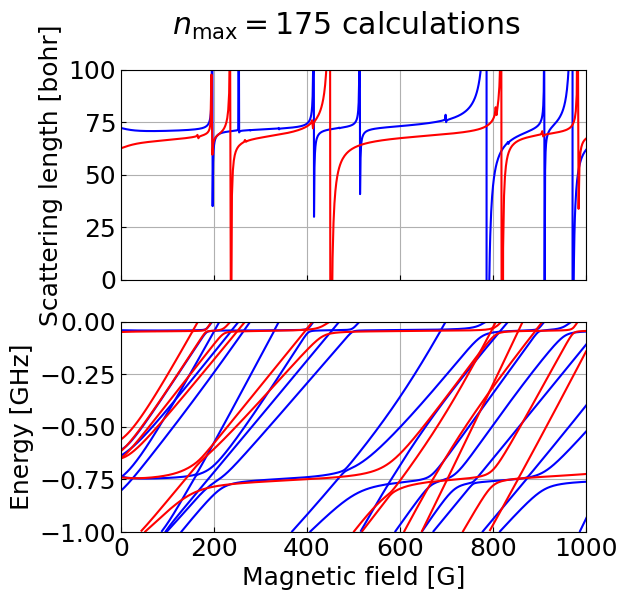

In [16]:
fig, axes = utility.plot_many(2, 1, shape=(6, 6), sharex=True)

filename = f"{DATA_PATH}/molscat_n_max_175_scaled_1.dat"
data = np.loadtxt(filename, delimiter="\t", skiprows=1)

axes[0].plot(data[:, 1], data[:, 2] * ANGS, color = "blue")

axes[0].set_ylabel(f"Scattering length [bohr]")
axes[0].set_ylim(0, 100);

bounds_single = BoundsDependence(f"{DATA_PATH}/bound_n_max_175_scaled_1.dat")
for state in bounds_single.states():
	axes[1].plot(state[:, 0], state[:, 1], color = "blue")
	
axes[1].set_ylabel(f"Energy [GHz]")
axes[1].set_xlabel("Magnetic field [G]")
axes[1].set_ylim(-1, 0);
axes[1].set_xlim(0, 1000);

scatterings = ScatteringDependence.parse_json(f"{DATA_PATH}/SrF_Rb_scattering_n_max_10_scaled_v1.json")
axes[0].plot(scatterings.parameters, scatterings.s_lengths().real, color = "red")

bounds = BoundsDependence.parse_json(f"{DATA_PATH}/SrF_Rb_bound_states_n_max_10_scaled_v1.json")
for state in bounds.states():
	axes[1].plot(state[:, 0], state[:, 1], color = "red")

# fig.savefig(f"{SAVE_PATH}/feshbach_n_175.pdf", bbox_inches = "tight")
fig.suptitle(r"$n_\text{max} = 175$ calculations");

# n_max = 10 calculations

## Singlet reconstruction

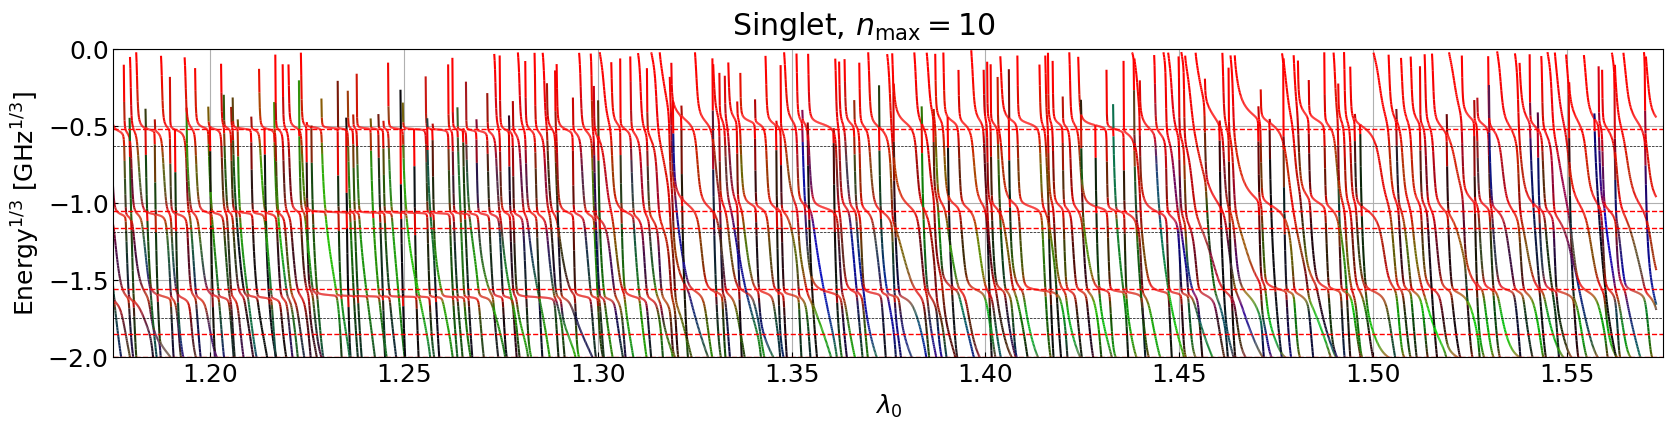

In [12]:
fig, ax = utility.plot(shape = (20, 4))

bounds = BoundsDependence.parse_json(f"{DATA_PATH}/SrF_Rb_bounds_singlet_scaling_full_n_max_10_invariant_v2.json")

plot_bounds(ax, bounds)

for b in reference_singlet_scaled_1:
    ax.axhline(np.cbrt(b), color = "red", linestyle="--", linewidth=1)

for b in BINS:
    ax.axhline(np.cbrt(b), color = "black", linestyle="--", linewidth=0.5)

ax.set_ylabel("Energy$^{1/3}$ [GHz$^{1/3}$]")
ax.set_xlabel(r"$\lambda_0$")
ax.set_ylim(-2, 0);
ax.set_xlim(1.375 - 0.2, 1.375 + 0.2);

# fig.savefig(f"{SAVE_PATH}/srf_rb_singlet_bounds_n_10.pdf", bbox_inches = "tight")
fig.suptitle(r"Singlet, $n_\text{max} = 10$");

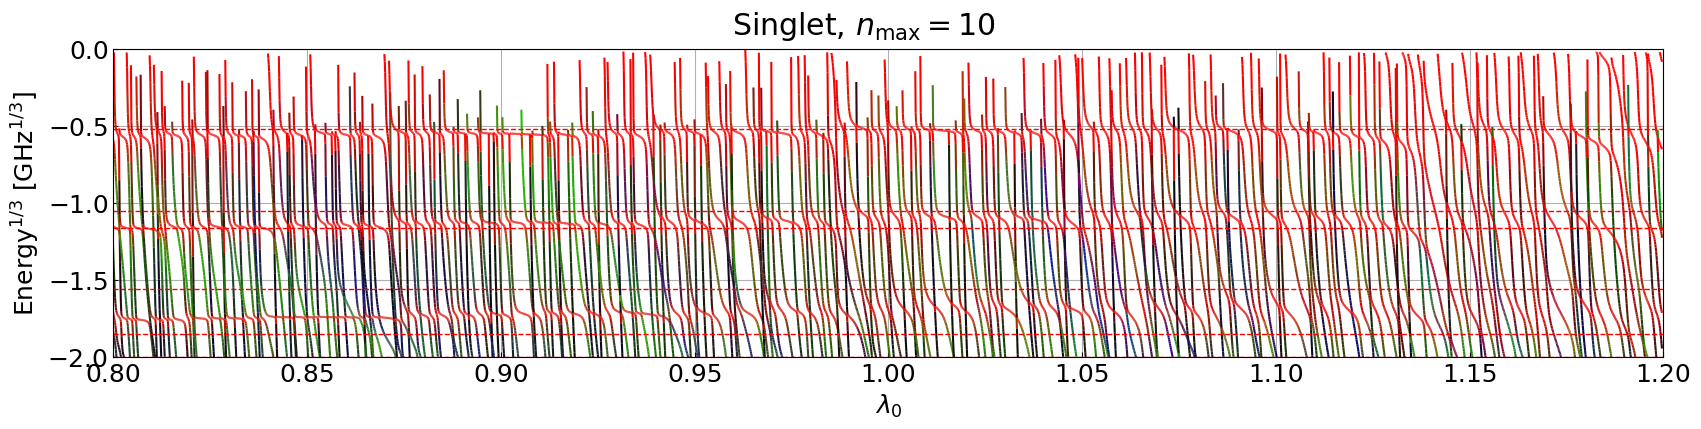

In [4]:
fig, ax = utility.plot(shape = (20, 4))

bounds = BoundsDependence.parse_json(f"{DATA_PATH}/SrF_Rb_bounds_singlet_scaling_full_n_max_10_invariant_s_1.json")

plot_bounds(ax, bounds)

for b in reference_singlet_scaled_1:
    ax.axhline(np.cbrt(b), color = "red", linestyle="--", linewidth=1)

ax.set_ylabel("Energy$^{1/3}$ [GHz$^{1/3}$]")
ax.set_xlabel(r"$\lambda_0$")
ax.set_ylim(-2, 0);
ax.set_xlim(1.0 - 0.2, 1.0 + 0.2);

# fig.savefig(f"{SAVE_PATH}/srf_rb_singlet_bounds_n_10.pdf", bbox_inches = "tight")
fig.suptitle(r"Singlet, $n_\text{max} = 10$");

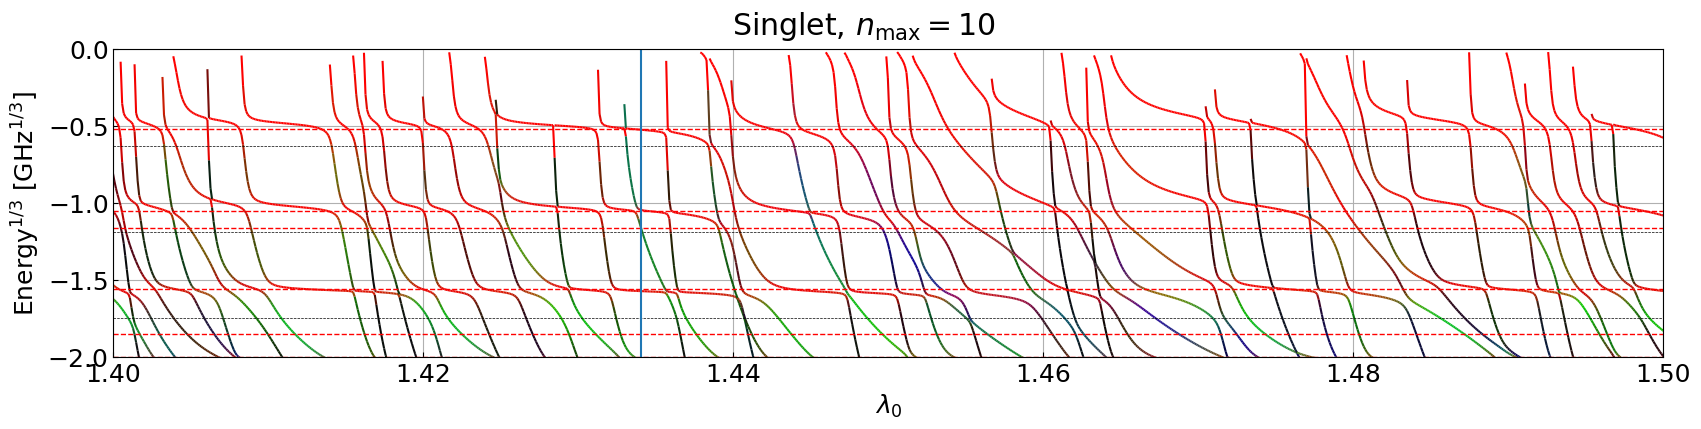

In [14]:
fig, ax = utility.plot(shape = (20, 4))

bounds = BoundsDependence.parse_json(f"{DATA_PATH}/SrF_Rb_bounds_singlet_scaling_full_n_max_10_invariant_v2.json")

plot_bounds(ax, bounds)

for b in reference_singlet_scaled_1:
    ax.axhline(np.cbrt(b), color = "red", linestyle="--", linewidth=1)

for b in BINS:
    ax.axhline(np.cbrt(b), color = "black", linestyle="--", linewidth=0.5)

ax.set_ylabel("Energy$^{1/3}$ [GHz$^{1/3}$]")
ax.set_xlabel(r"$\lambda_0$")
ax.set_ylim(-2, 0);
ax.set_xlim(1.45 - 0.05, 1.45 + 0.05);

ax.axvline(1.43405)

# fig.savefig(f"{SAVE_PATH}/srf_rb_singlet_bounds_n_10.pdf", bbox_inches = "tight")
fig.suptitle(r"Singlet, $n_\text{max} = 10$");

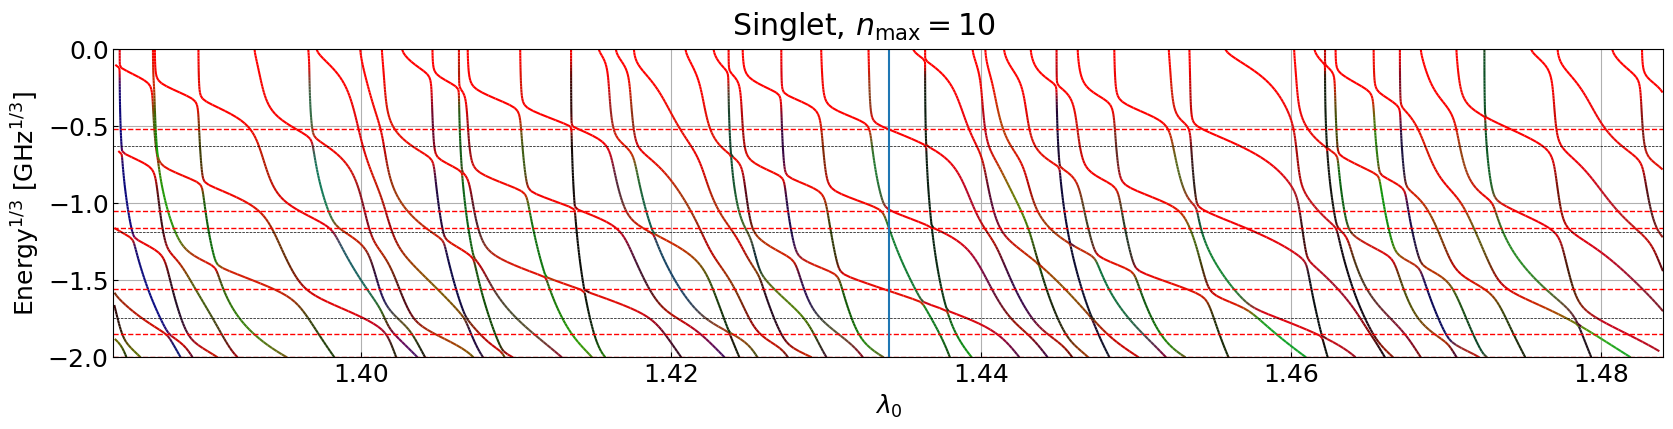

In [19]:
fig, ax = utility.plot(shape = (20, 4))

bounds = BoundsDependence.parse_field_json(f"{DATA_PATH}/SrF_Rb_field_singlet_scaling_full_n_max_10_1_43.json")

plot_bounds(ax, bounds)

for b in reference_singlet_scaled_1:
    ax.axhline(np.cbrt(b), color = "red", linestyle="--", linewidth=1)

for b in BINS:
    ax.axhline(np.cbrt(b), color = "black", linestyle="--", linewidth=0.5)

ax.set_ylabel("Energy$^{1/3}$ [GHz$^{1/3}$]")
ax.set_xlabel(r"$\lambda_0$")
ax.set_ylim(-2, 0);
ax.set_xlim(1.434 - 0.05, 1.434 + 0.05)

ax.axvline(1.4340338097242147)

# fig.savefig(f"{SAVE_PATH}/srf_rb_singlet_bounds_n_10.pdf", bbox_inches = "tight")
fig.suptitle(r"Singlet, $n_\text{max} = 10$");

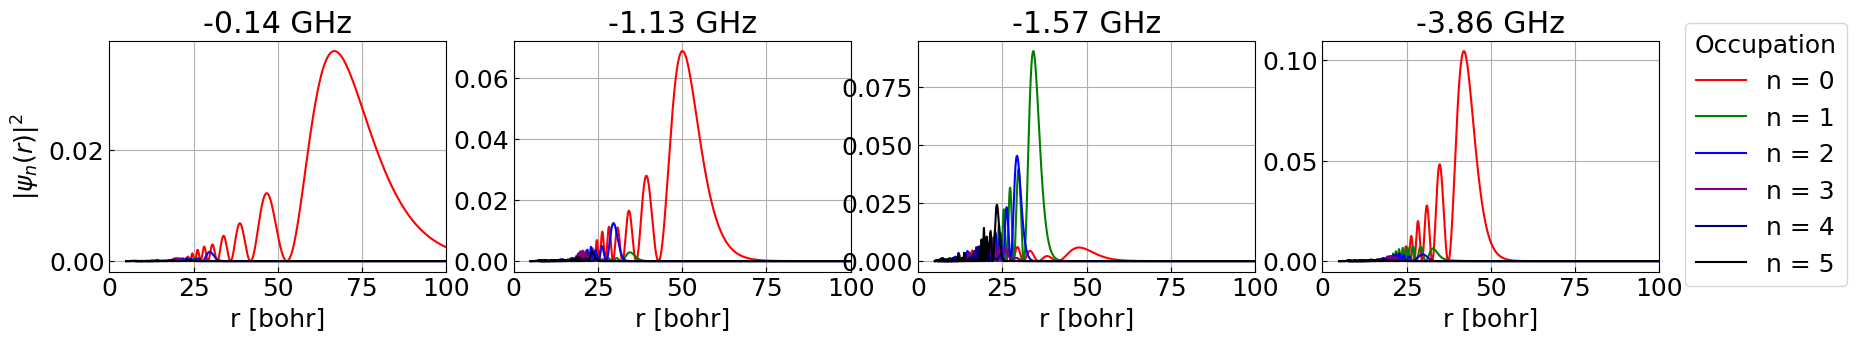

In [33]:
max_coeff = 5
waves = wavefunction_json(f"{DATA_PATH}/SrF_Rb_bounds_singlet_wave_functions_n_max_10_scaling_1_43.json", take = max_coeff + 1)

take = 4

fig, axes = utility.plot_many(1, take, shape = (5 * take, 3))
axes[0].set_ylabel(r"$|\psi_n(r)|^2$")

for i, (state, wave) in itertools.islice(enumerate(waves.items()), take):
    for j in range(wave.values.shape[1]):
        axes[i].plot(wave.distances, wave.values[:, j]**2, color = colors[j])
    axes[i].set_xlabel("r [bohr]")
    axes[i].set_title(f"{wave.energy:.2f} GHz")
    axes[i].set_xlim(0, 100)

fig.legend([f"n = {j}" for j in range(max_coeff + 1)],
           loc='center right', bbox_to_anchor=(1, 0.5),
           title='Occupation');

# fig.savefig(f"{SAVE_PATH}/wave_function_triplet_scaled_n_10.pdf", bbox_inches = "tight")

interactive(children=(IntSlider(value=0, description='scaling_index', max=20), Output()), _dom_classes=('widge…

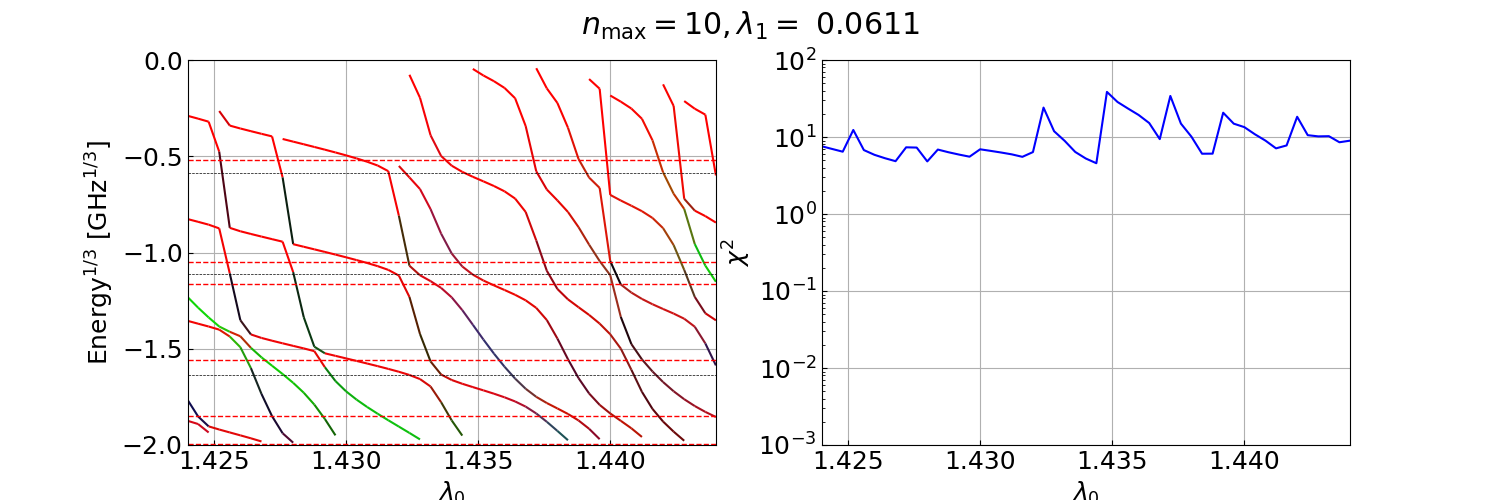

In [2]:
%matplotlib widget

bounds_singlet_2d_zoomed = BoundsDependence2D.parse_json(f"{DATA_PATH}/SrF_Rb_bounds_singlet_2d_scaling_legendre_0_legendre_1_n_max_10_morphing_1_43.json")

fig, axes = plot_2d_bounds(bounds_singlet_2d_zoomed, reference_singlet_scaled_1, c6_mult=1.445, label = r"$n_\text{max} = 10, \lambda_1 =$")

axes[0].set_ylabel("Energy$^{1/3}$ [GHz$^{1/3}$]")
axes[0].set_xlabel(r"$\lambda_0$")
axes[0].set_ylim(-2, 0)
axes[0].set_xlim(1.434 - 0.01, 1.434 + 0.01)

axes[1].set_yscale("log")
axes[1].set_ylim(1e-3, 1e2)
axes[1].set_ylabel(r"$\chi^2$")
axes[1].set_xlabel(r"$\lambda_0$");

## Triplet reconstruction

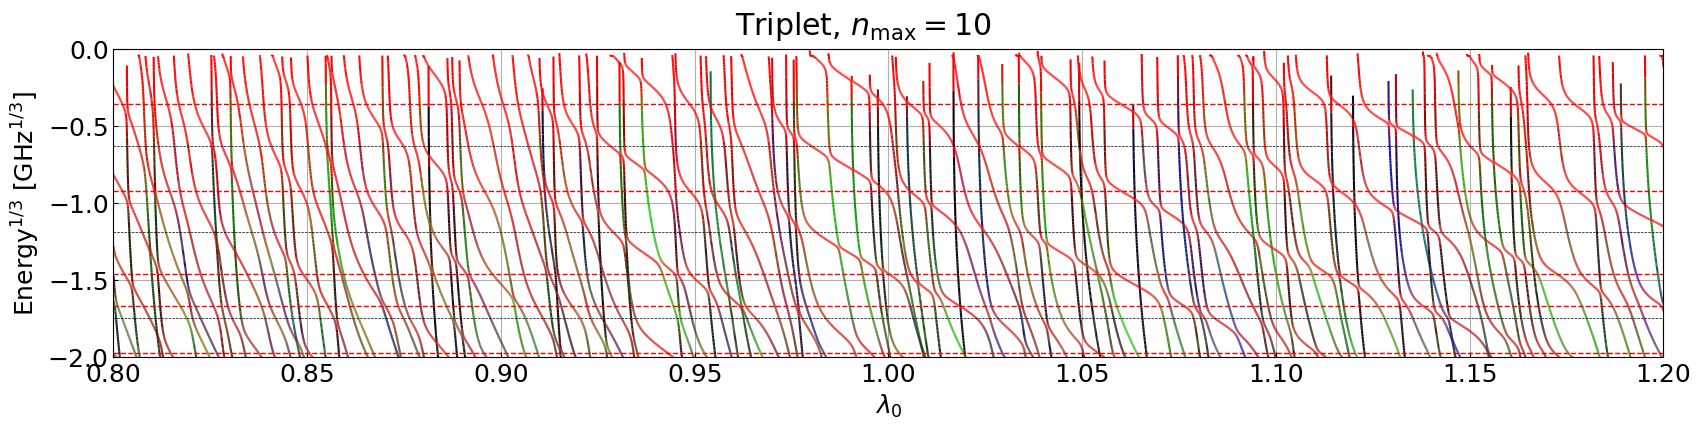

In [50]:
fig, ax = utility.plot(shape = (20, 4))

bounds = BoundsDependence.parse_json(f"{DATA_PATH}/SrF_Rb_bounds_triplet_scaling_full_n_max_10_long.json", (1 - 0.2, 1 + 0.2))

plot_bounds(ax, bounds)

for b in reference_triplet_scaled_1:
    ax.axhline(np.cbrt(b), color = "red", linestyle="--", linewidth=1)

for b in BINS:
    ax.axhline(np.cbrt(b), color = "black", linestyle="--", linewidth=0.5)

ax.set_ylabel("Energy$^{1/3}$ [GHz$^{1/3}$]")
ax.set_xlabel(r"$\lambda_0$")
ax.set_ylim(-2, 0);
ax.set_xlim(1. - 0.2, 1. + 0.2);

# fig.savefig(f"{SAVE_PATH}/srf_rb_triplet_bounds_n_10.pdf", bbox_inches = "tight")
fig.suptitle(r"Triplet, $n_\text{max} = 10$");

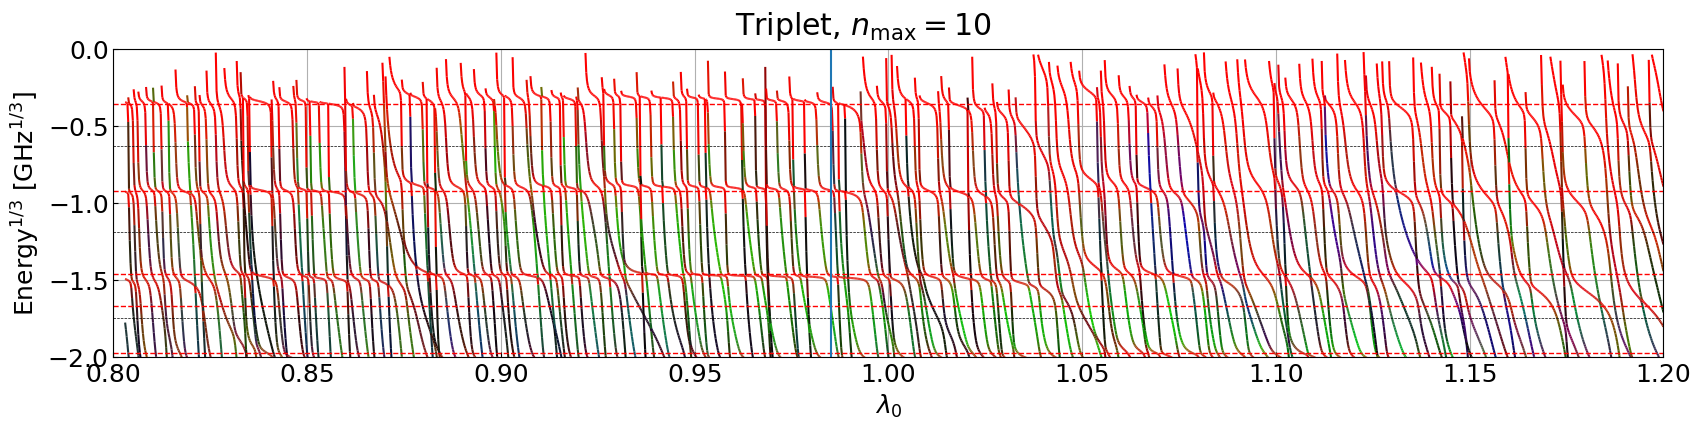

In [9]:
fig, ax = utility.plot(shape = (20, 4))

bounds = BoundsDependence.parse_json(f"{DATA_PATH}/SrF_Rb_bounds_triplet_scaling_full_n_max_10_invariant.json", (1 - 0.2, 1 + 0.2))

plot_bounds(ax, bounds)

for b in reference_triplet_scaled_1:
    ax.axhline(np.cbrt(b), color = "red", linestyle="--", linewidth=1)

for b in BINS:
    ax.axhline(np.cbrt(b), color = "black", linestyle="--", linewidth=0.5)

ax.set_ylabel("Energy$^{1/3}$ [GHz$^{1/3}$]")
ax.set_xlabel(r"$\lambda_0$")
ax.set_ylim(-2, 0);
ax.set_xlim(1. - 0.2, 1. + 0.2);

ax.axvline(0.9851)

# fig.savefig(f"{SAVE_PATH}/srf_rb_triplet_bounds_n_10.pdf", bbox_inches = "tight")
fig.suptitle(r"Triplet, $n_\text{max} = 10$");

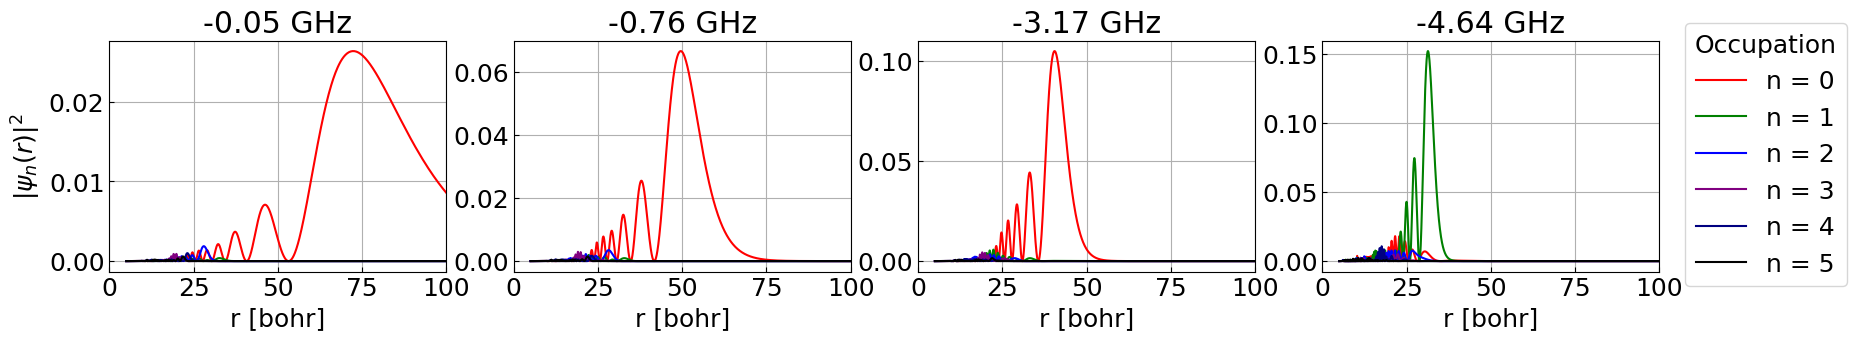

In [11]:
max_coeff = 5
waves = wavefunction_json(f"{DATA_PATH}/SrF_Rb_bounds_triplet_wave_functions_n_max_10_morphing_1.json", take = max_coeff + 1)

take = 4

fig, axes = utility.plot_many(1, take, shape = (5 * take, 3))
axes[0].set_ylabel(r"$|\psi_n(r)|^2$")

for i, (state, wave) in itertools.islice(enumerate(waves.items()), take):
    for j in range(wave.values.shape[1]):
        axes[i].plot(wave.distances, wave.values[:, j]**2, color = colors[j])
    axes[i].set_xlabel("r [bohr]")
    axes[i].set_title(f"{wave.energy:.2f} GHz")
    axes[i].set_xlim(0, 100)

fig.legend([f"n = {j}" for j in range(max_coeff + 1)],
           loc='center right', bbox_to_anchor=(1, 0.5),
           title='Occupation');

# fig.savefig(f"{SAVE_PATH}/wave_function_triplet_scaled_n_10.pdf", bbox_inches = "tight")

# ABM

In [2]:
max_coeff = 175
parsed_singlet = parse_wavefunction_file(f'{DATA_PATH}/wave_function_singlet_175.output', 176, max_coeff = max_coeff)
parsed_singlet_scaled = parse_wavefunction_file(f'{DATA_PATH}/wave_function_singlet_175_scaled.output', 176, max_coeff = max_coeff)
parsed_triplet = parse_wavefunction_file(f'{DATA_PATH}/wave_function_triplet_175.output', 176, max_coeff = max_coeff)
parsed_triplet_scaled = parse_wavefunction_file(f'{DATA_PATH}/wave_function_triplet_175_scaled.output', 176, max_coeff = max_coeff)

In [ ]:
singlet_waves = list(map(lambda x: x[1], reversed(parsed_singlet.items())))
singlet_scaled_waves = list(map(lambda x: x[1], reversed(parsed_singlet_scaled.items())))
triplet_waves = list(map(lambda x: x[1], reversed(parsed_triplet.items())))
triplet_scaled_waves = list(map(lambda x: x[1], reversed(parsed_triplet_scaled.items())))

In [3]:
import abm_py as abm

rb = abm.HifiProblemBuilder(1, 3)
rb.with_hyperfine_coupling(0.113990 * CMINV)

srf = abm.HifiProblemBuilder(1, 1)
srf.with_hyperfine_coupling((3.2383e-3 + 1.0096e-3 / 3.) * CMINV)

srf_rb = abm.DoubleHifiProblemBuilder(srf, rb)
srf_rb.with_projection(2)

mag_fields = np.linspace(0, 1000, 500)
states = np.array(srf_rb.build().states_range(mag_fields)) / GHZ

def calc_fc_factors(singlet, triplet):
    return np.trapezoid(np.sum(singlet["coeffs"] * triplet["coeffs"], axis = -1), triplet["r"])

from scipy.interpolate import make_interp_spline
def calc_fc_factors_diff_grid(singlet, triplet):
    spline = make_interp_spline(singlet["r"], singlet["coeffs"])
    singlet_coeffs = spline(triplet["r"])

    return np.trapezoid(np.sum(singlet_coeffs * triplet["coeffs"], axis = -1), triplet["r"])

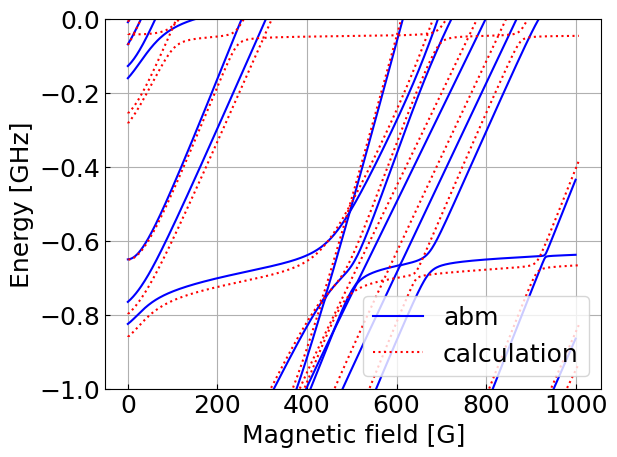

In [5]:
srf_rb_abm = abm.ABMProblemBuilder(srf, rb)
srf_rb_abm.with_projection(2)

singlet_energies = np.array(list(map(lambda x: x["energy"], singlet_waves)))[0:7] * GHZ
triplet_energies = np.array(list(map(lambda x: x["energy"], triplet_waves)))[0:7] * GHZ

fc_factors = np.zeros((singlet_energies.shape[0], triplet_energies.shape[0]))
for i in range(fc_factors.shape[0]):
    for j in range(fc_factors.shape[1]):
        fc_factors[i, j] = calc_fc_factors(singlet_waves[i], triplet_waves[j])

srf_rb_abm.with_vibrational(singlet_energies, triplet_energies, fc_factors.flatten())

states_abm = np.array(srf_rb_abm.build().states_range(mag_fields)) / GHZ

fig, ax = utility.plot()
ax.plot(mag_fields, states_abm - states[:, 0:1], color = "blue")

bounds_single = BoundsDependence(f"{DATA_PATH}/bound_n_max_175.dat")
for state in bounds_single.states():
	ax.plot(state[:, 0], state[:, 1], color = "red", linestyle = ":")

ax.set_ylim(-1, 0)
ax.legend([ax.lines[0], ax.lines[-1]], ["abm", "calculation"], loc = "lower right")
ax.set_xlabel("Magnetic field [G]")
ax.set_ylabel("Energy [GHz]");

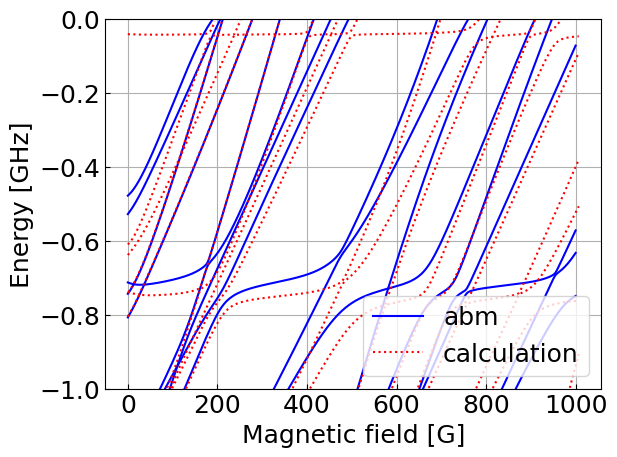

In [14]:
srf_rb_abm = abm.ABMProblemBuilder(srf, rb)
srf_rb_abm.with_projection(2)

singlet_energies = np.array(list(map(lambda x: x["energy"], singlet_scaled_waves)))[0:7] * GHZ
triplet_energies = np.array(list(map(lambda x: x["energy"], triplet_scaled_waves)))[0:7] * GHZ

fc_factors = np.zeros((singlet_energies.shape[0], triplet_energies.shape[0]))
for i in range(fc_factors.shape[0]):
    for j in range(fc_factors.shape[1]):
        fc_factors[i, j] = calc_fc_factors(singlet_scaled_waves[i], triplet_scaled_waves[j])

srf_rb_abm.with_vibrational(singlet_energies, triplet_energies, fc_factors.flatten())

states_abm = np.array(srf_rb_abm.build().states_range(mag_fields)) / GHZ

fig, ax = utility.plot()
ax.plot(mag_fields, states_abm - states[:, 0:1], color = "blue")

bounds_single = BoundsDependence(f"{DATA_PATH}/bound_n_max_175_scaled_1.dat")
for state in bounds_single.states():
	ax.plot(state[:, 0], state[:, 1], color = "red", linestyle = ":")

ax.set_ylim(-1, 0)
ax.legend([ax.lines[0], ax.lines[-1]], ["abm", "calculation"], loc = "lower right")
ax.set_xlabel("Magnetic field [G]")
ax.set_ylabel("Energy [GHz]");

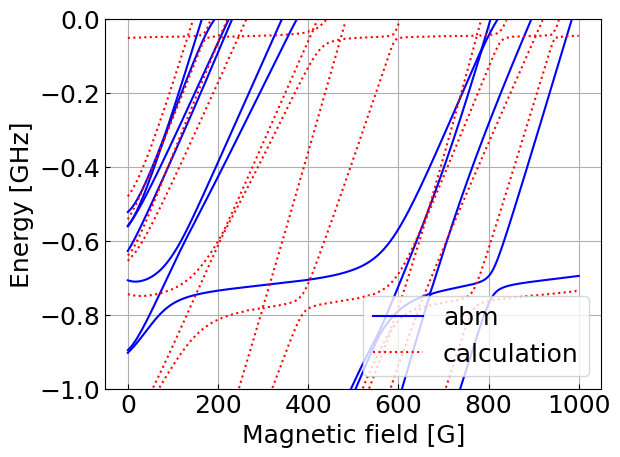

In [8]:
srf_rb_abm = abm.ABMProblemBuilder(srf, rb)
srf_rb_abm.with_projection(2)

singlets = wavefunction_json(f"{DATA_PATH}/SrF_Rb_bounds_singlet_wave_functions_n_max_10_.json")
singlets = list(map(lambda x: x[1].to_dict(), singlets.items()))

triplets = parse_wavefunction_file(f"{DATA_PATH}/bound_wave_triplet_n_10_scaled_1.007_v2.output", 11)
triplets = list(map(lambda x: x[1], reversed(triplets.items())))

singlet_energies = np.array(list(map(lambda x: x["energy"], singlets)))[0:6] * GHZ
triplet_energies = np.array(list(map(lambda x: x["energy"], triplets)))[0:6] * GHZ

fc_factors = np.zeros((singlet_energies.shape[0], triplet_energies.shape[0]))
for i in range(fc_factors.shape[0]):
    for j in range(fc_factors.shape[1]):
        fc_factors[i, j] = calc_fc_factors_diff_grid(singlets[i], triplets[j])

srf_rb_abm.with_vibrational(singlet_energies, triplet_energies, fc_factors.flatten())

states_abm = np.array(srf_rb_abm.build().states_range(mag_fields)) / GHZ

fig, ax = utility.plot()
ax.plot(mag_fields, states_abm - states[:, 0:1], color = "blue")

bounds_single = BoundsDependence.parse_json(f"{DATA_PATH}/SrF_Rb_bound_states_n_max_10_scaled_v0.json")
for state in bounds_single.states():
	ax.plot(state[:, 0], state[:, 1], color = "red", linestyle = ":")

ax.set_ylim(-1, 0)
ax.legend([ax.lines[0], ax.lines[-1]], ["abm", "calculation"], loc = "lower right")
ax.set_xlabel("Magnetic field [G]")
ax.set_ylabel("Energy [GHz]");

# Testing


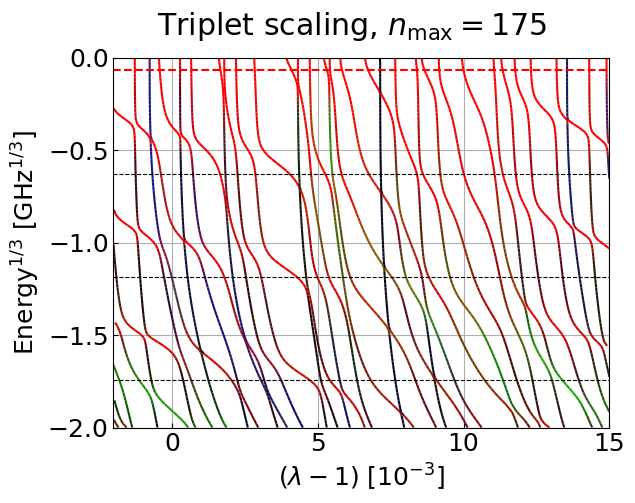

In [ ]:
fig, ax = utility.plot()

def scaling(a, center: float = 1., mult = 1000):
    return (a - center) * mult

plot_bounds(ax, BoundsDependence(f"{DATA_PATH}/field_triplet_n_175_wave_function.dat"), lambda x: scaling(x, 1))

for value in BINS:
    ax.axhline(np.cbrt(value), linestyle="--", color="black", linewidth=0.8)

ax.set_ylim(-2, 0)

ax.set_ylabel(f"Energy$^{{1/3}}$ [GHz$^{{1/3}}$]")
ax.set_xlim(-2, 15)

ax.set_xlabel(r"$(\lambda - 1)$ [$10^{-3}$]")

ax.axhline(np.cbrt(-0.00025193176848), linestyle="--", color="red")

fig.suptitle(r"Triplet scaling, $n_\text{max} = 175$ ");

In [11]:
spin = "triplet"
suffix = ""
energy_index = 92

file_suffix = f"_scale_{energy_index}{suffix}"
wave_suffix = f"_scale_{energy_index}_field{suffix}"

bounds = FieldOutput(f"{DATA_PATH}/field_{spin}_n_175_wave_function{file_suffix}.output", ScanParameter.PotScaling)
waves = parse_wavefunction_field_file(f"{DATA_PATH}/wave_function_{spin}_n_175{wave_suffix}.output", 176, max_coeff=20)


c:\Users\marcr\Documents\vs_code\numerical_rust_projects\quantum-rs\scattering-problems\analysis\../..\py_common\utility.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize = shape)


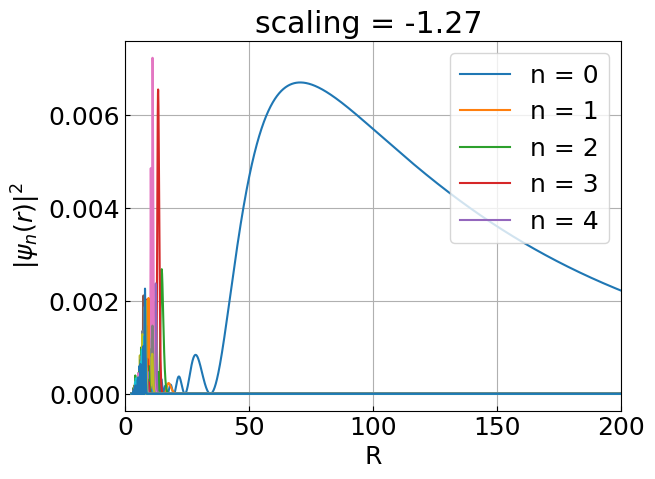

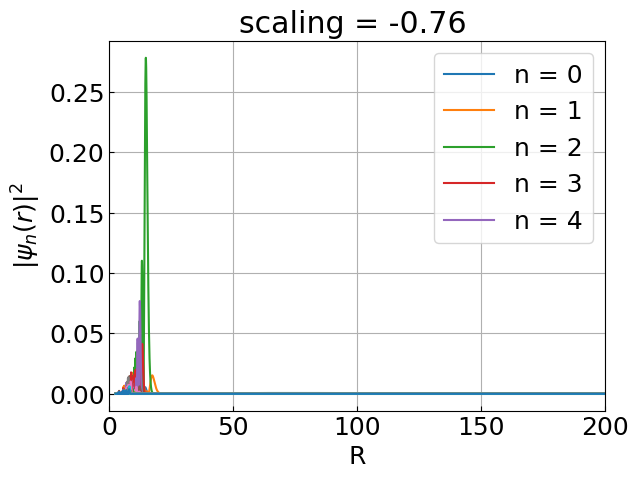

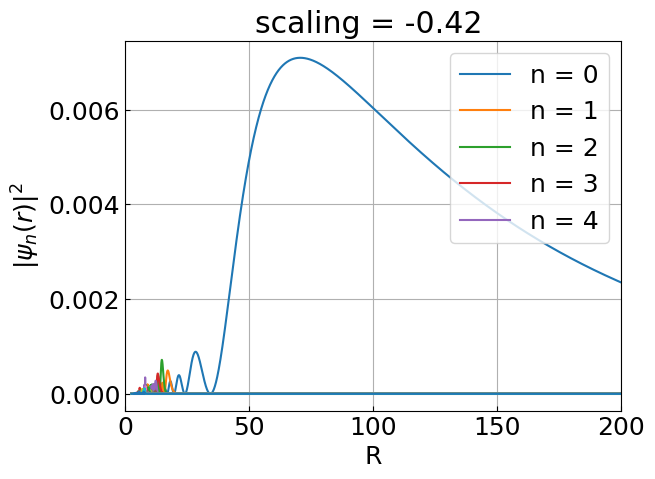

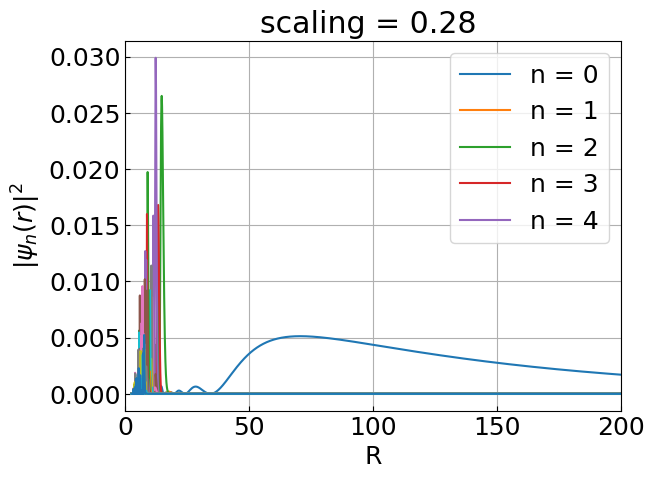

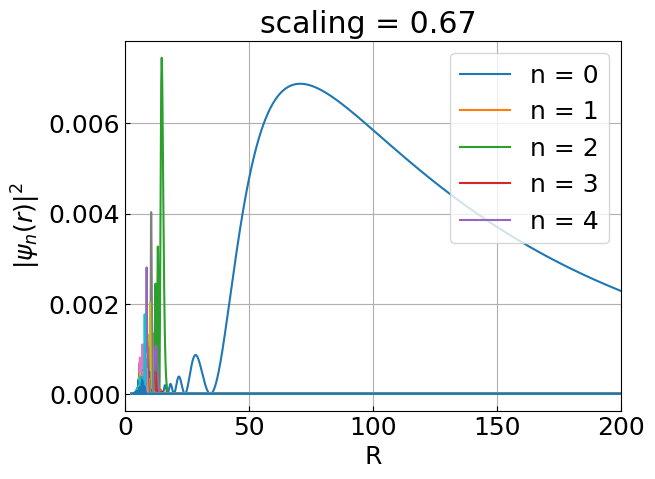

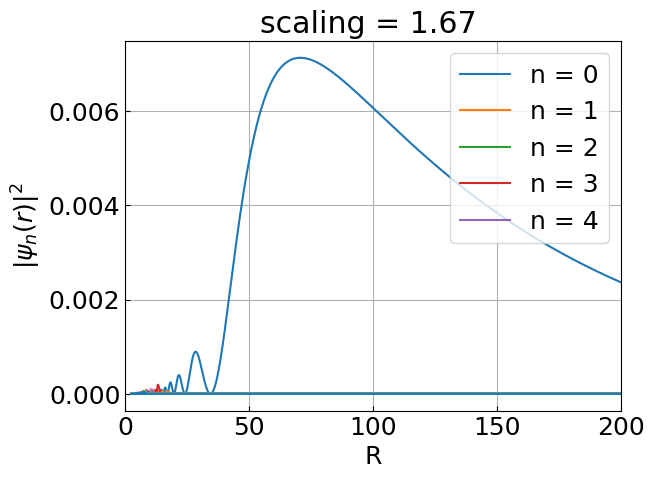

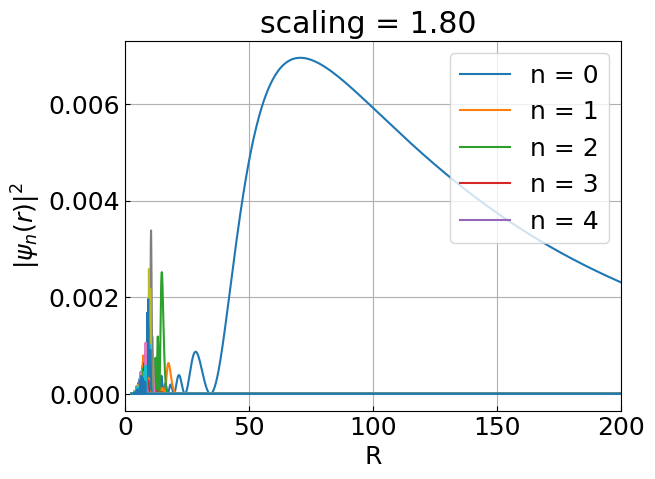

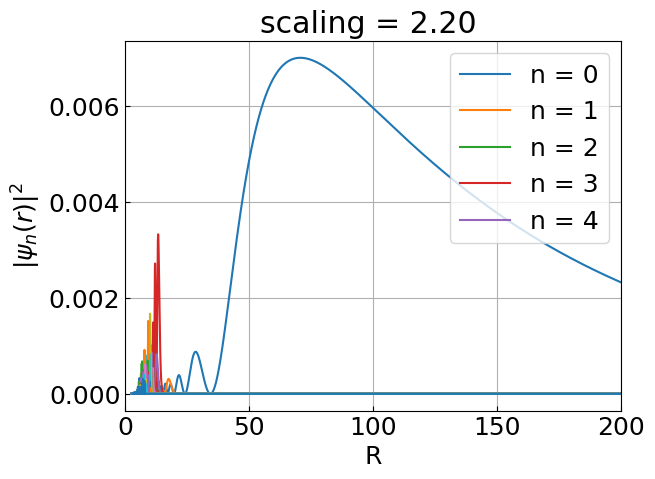

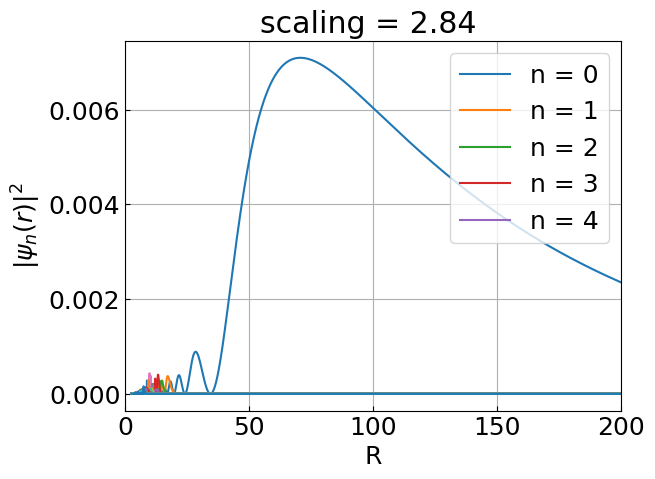

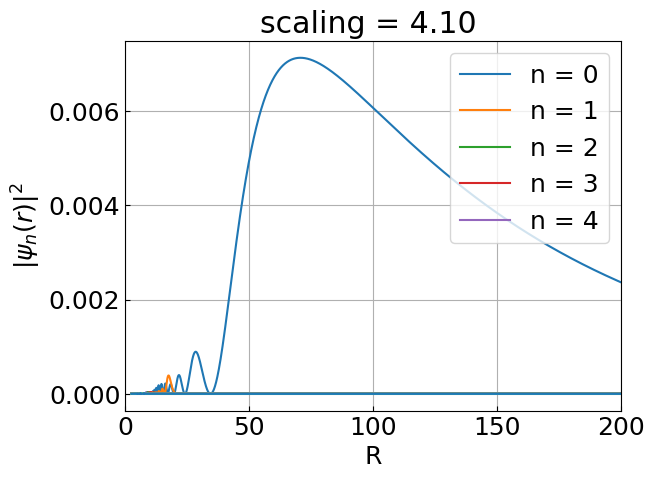

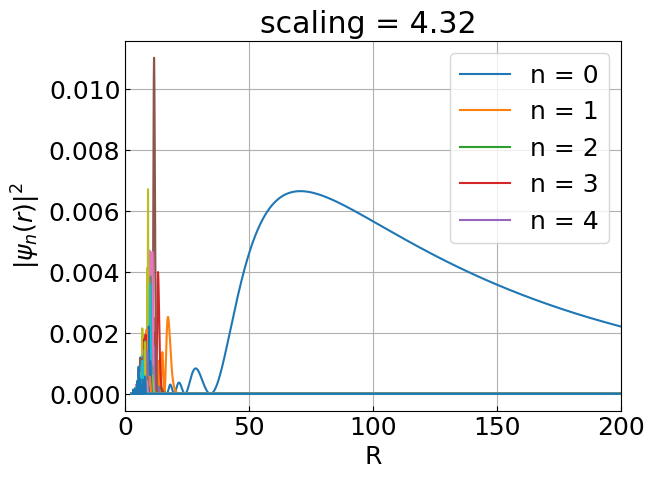

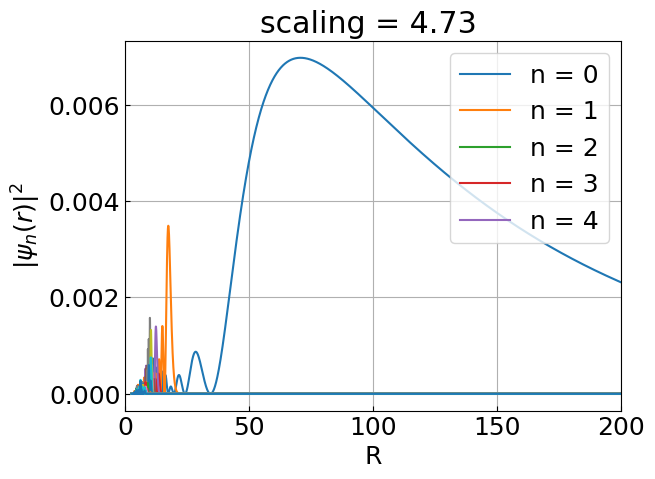

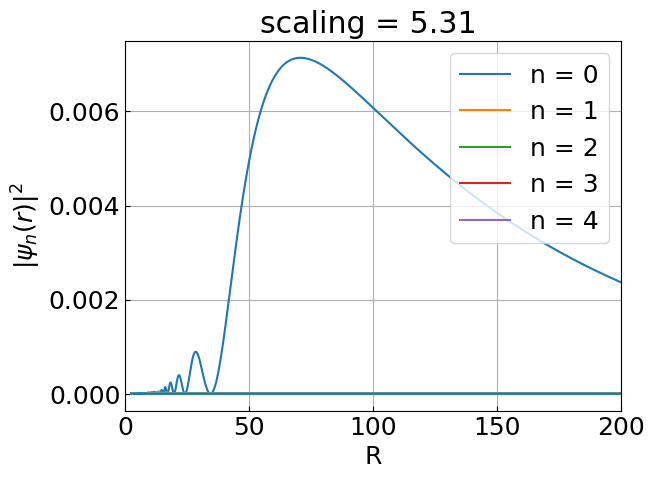

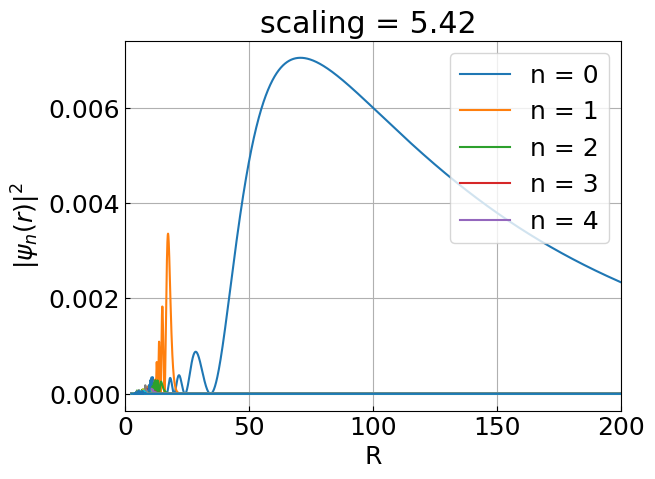

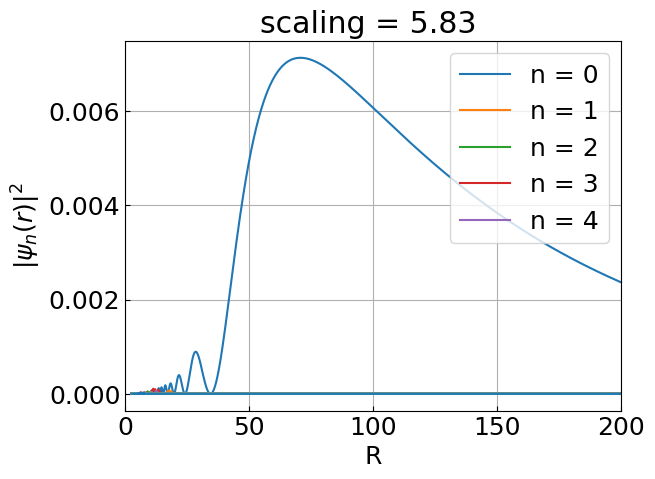

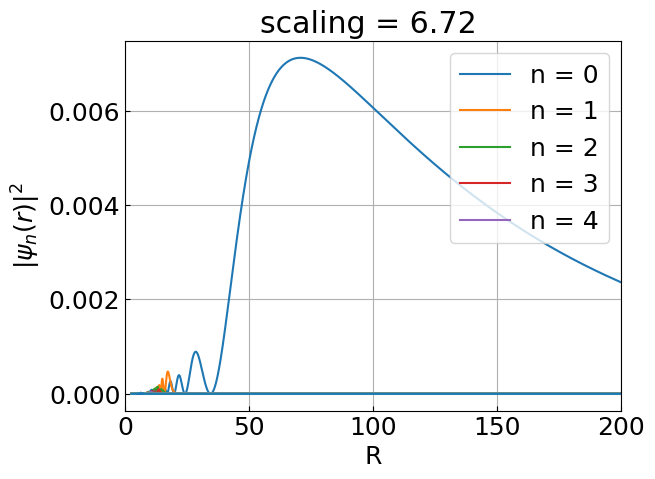

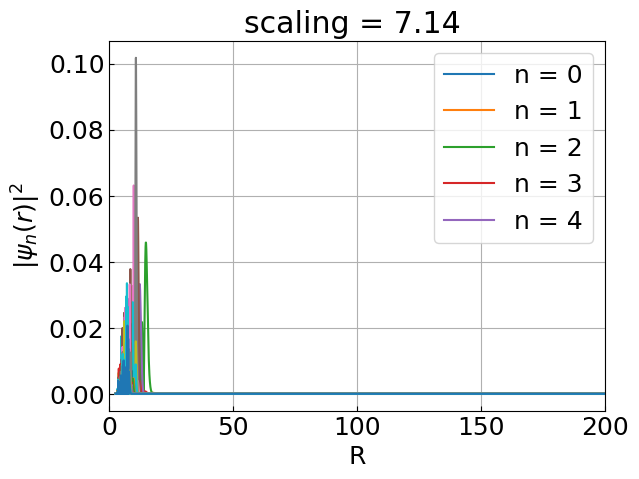

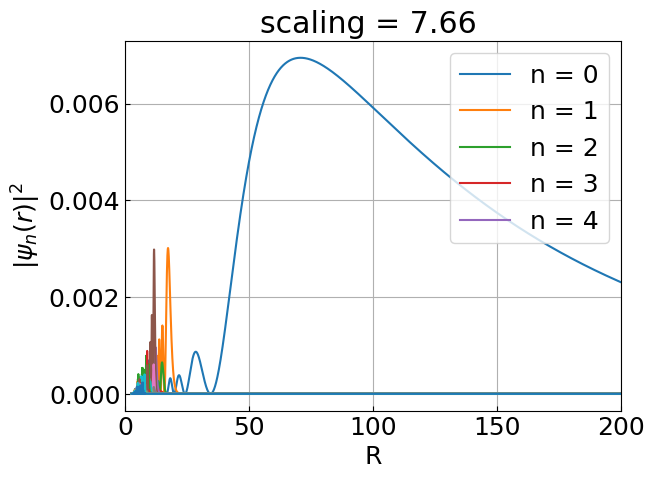

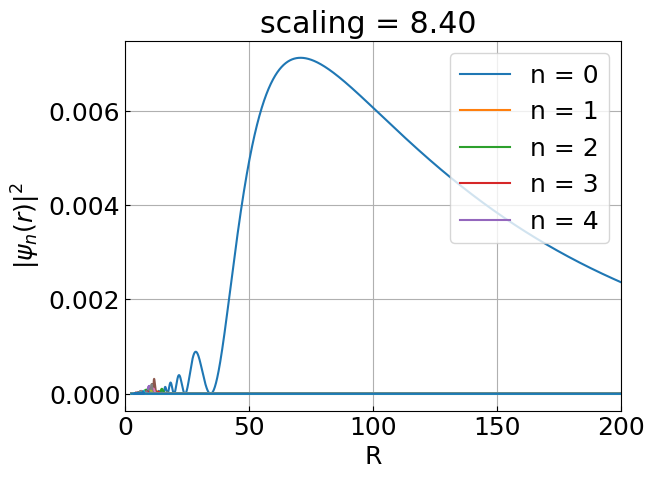

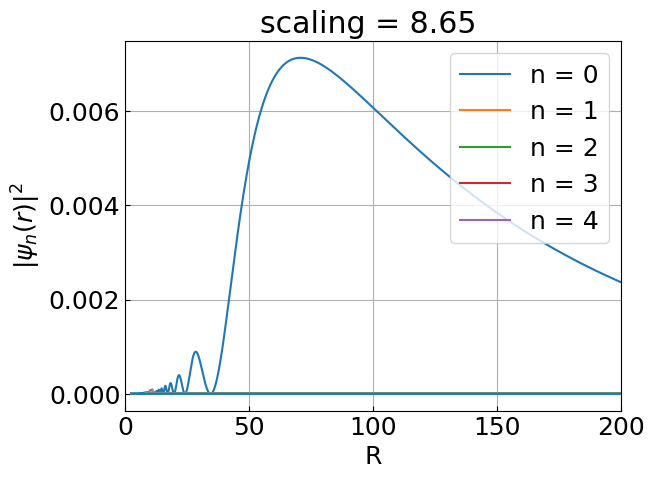

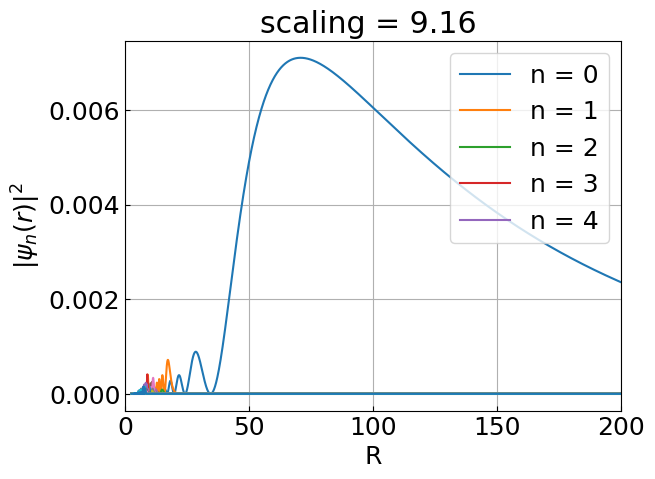

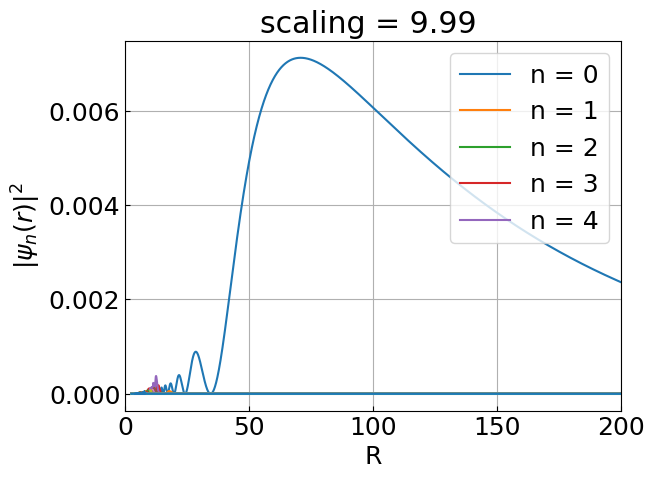

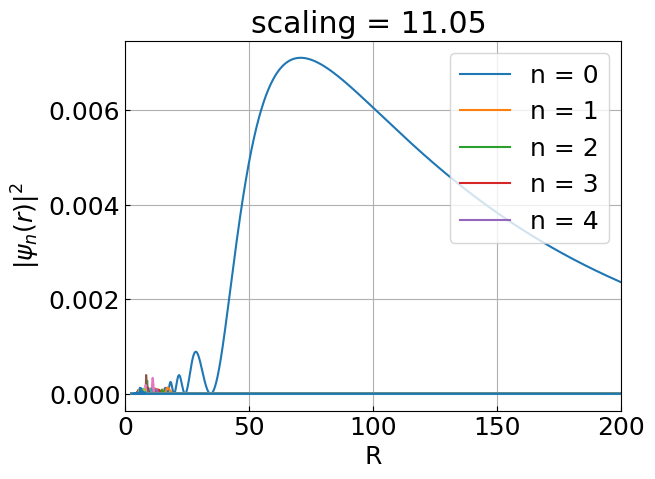

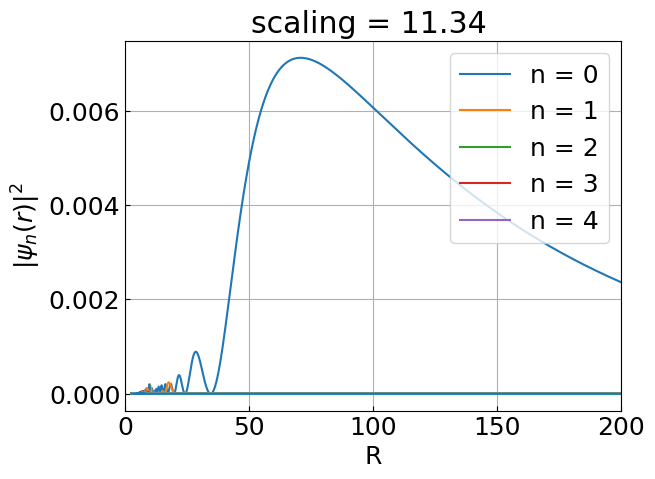

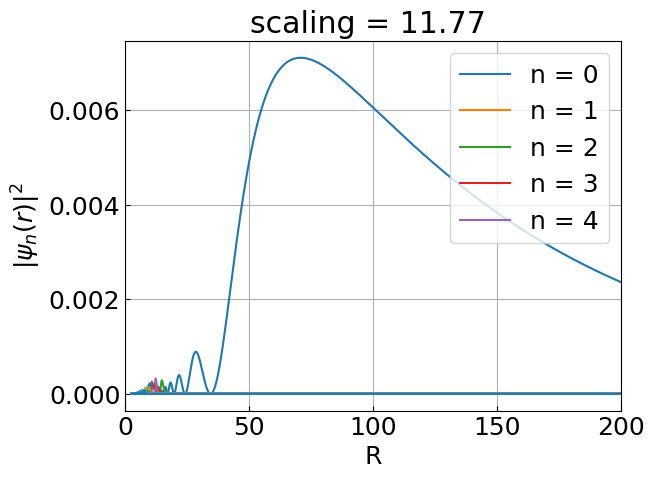

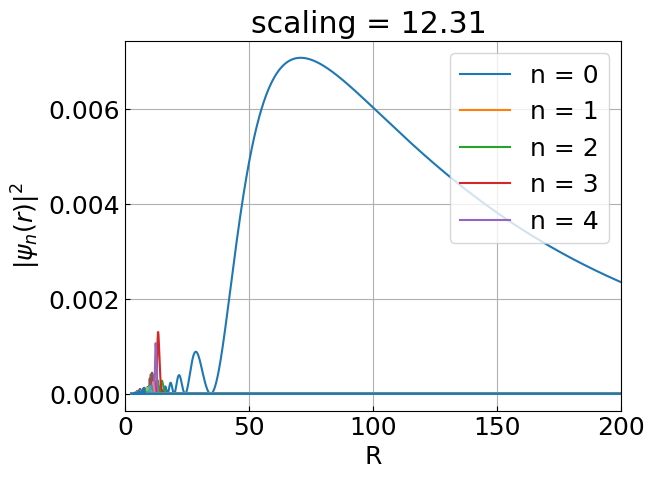

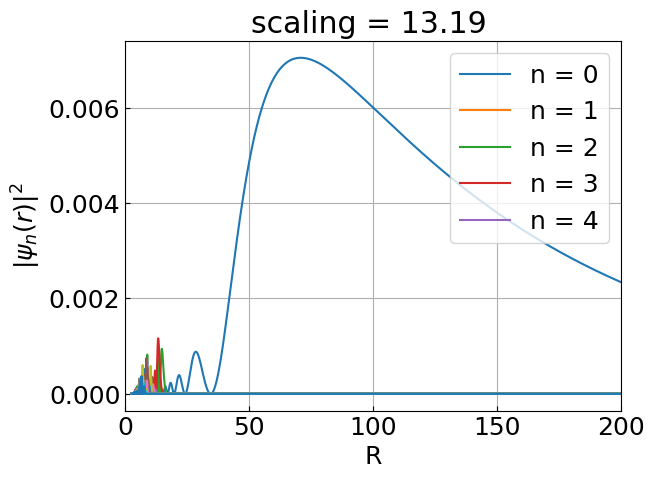

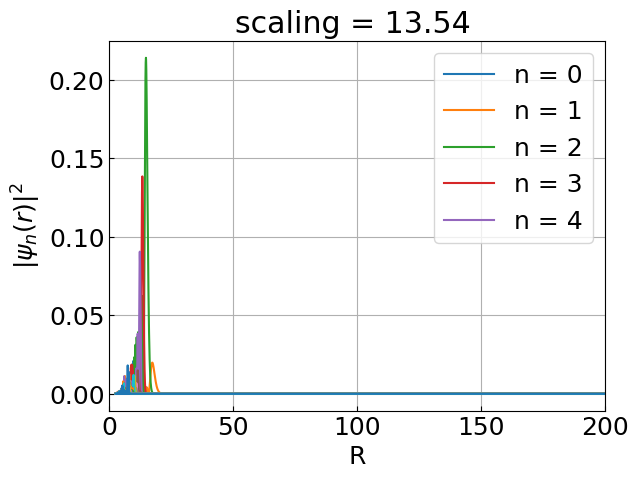

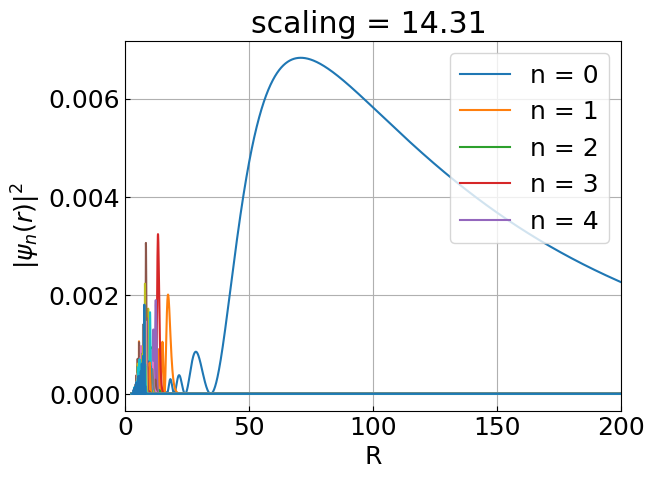

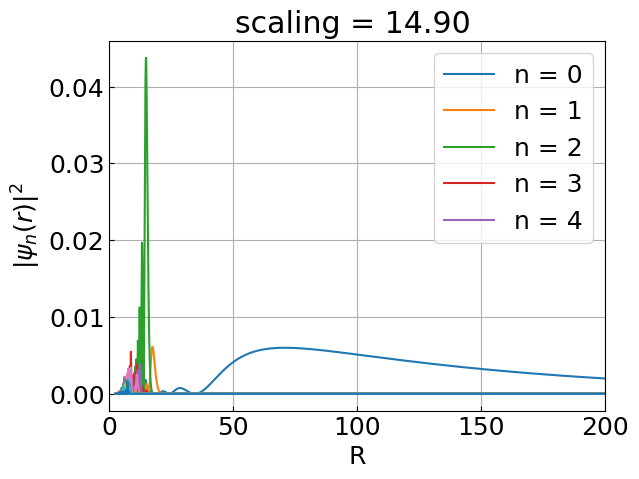

In [ ]:
for wave, (node, scaled) in zip(waves, bounds.matches[0].states):
    fig, ax = utility.plot()
    ax.set_ylabel(r"$|\psi_n(r)|^2$")
    ax.plot(wave["r"], wave["coeffs"]**2)

    ax.set_xlabel("R")
    ax.set_title(f"scaling = {scaling(scaled):.2f} ")
    ax.set_xlim(0, 200)
    ax.legend([f"n = {j}" for j in range(5)], loc = "upper right")
    
# fig.savefig(f"{SAVE_PATH}/wave_function_triplet_n_10_scaled_0,60.pdf", bbox_inches="tight")

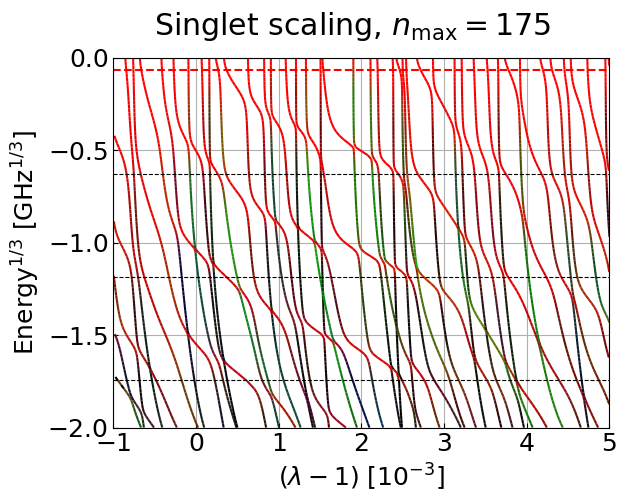

In [9]:
fig, ax = utility.plot()

def scaling(a, center: float = 1., mult = 1000):
    return (a - center) * mult

plot_bounds(ax, BoundsDependence(f"{DATA_PATH}/field_singlet_n_175_wave_function.dat"), lambda x: scaling(x, 1))

for value in BINS:
    ax.axhline(np.cbrt(value), linestyle="--", color="black", linewidth=0.8)

ax.set_ylim(-2, 0)

ax.set_ylabel(f"Energy$^{{1/3}}$ [GHz$^{{1/3}}$]")
ax.set_xlim(-1, 5)

ax.set_xlabel(r"$(\lambda - 1)$ [$10^{-3}$]")

ax.axhline(np.cbrt(-0.00025193176848), linestyle="--", color="red")

fig.suptitle(r"Singlet scaling, $n_\text{max} = 175$ ");

In [3]:
from py_common.aggregate_outputs import *
from py_common.wave_function import *

spin = "singlet"
suffix = ""
energy_index = 92

file_suffix = f"_scale_{energy_index}{suffix}"
wave_suffix = f"_scale_{energy_index}_field{suffix}"

bounds = FieldOutput(f"{DATA_PATH}/field_{spin}_n_175_wave_function{file_suffix}.output", ScanParameter.PotScaling)
waves = parse_wavefunction_field_file(f"{DATA_PATH}/wave_function_{spin}_n_175{wave_suffix}.output", 176, max_coeff=20)


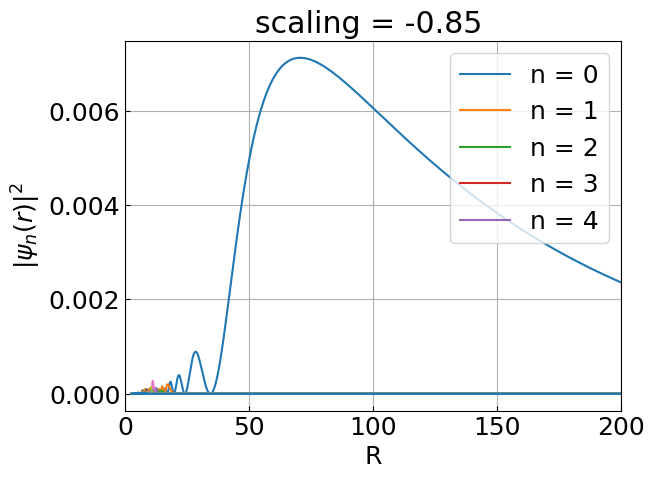

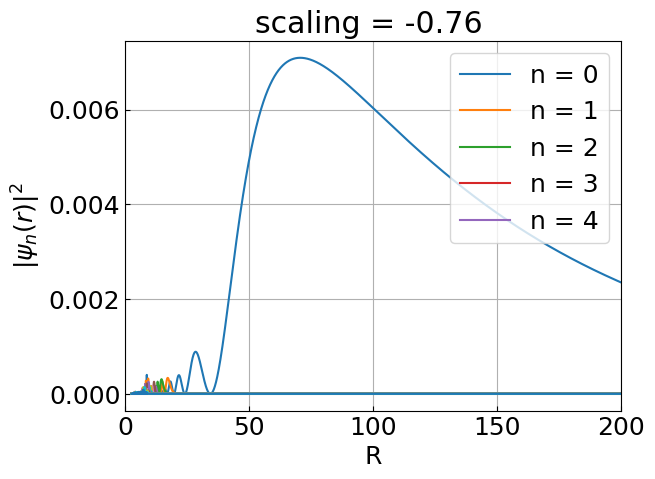

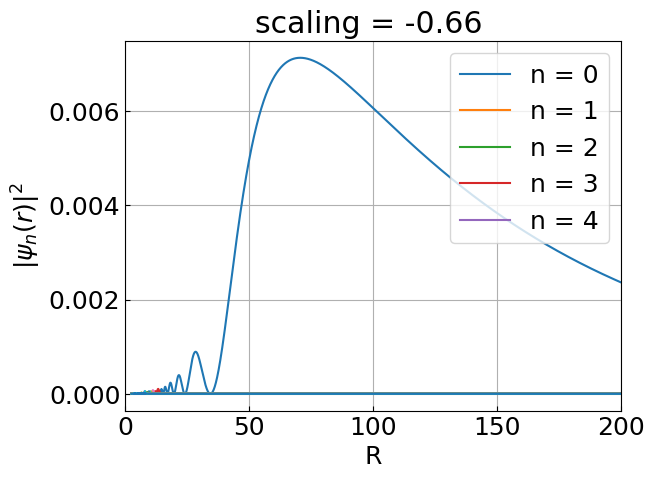

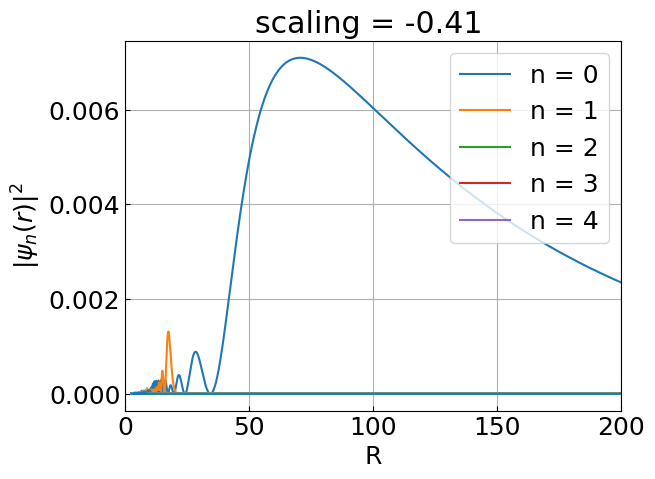

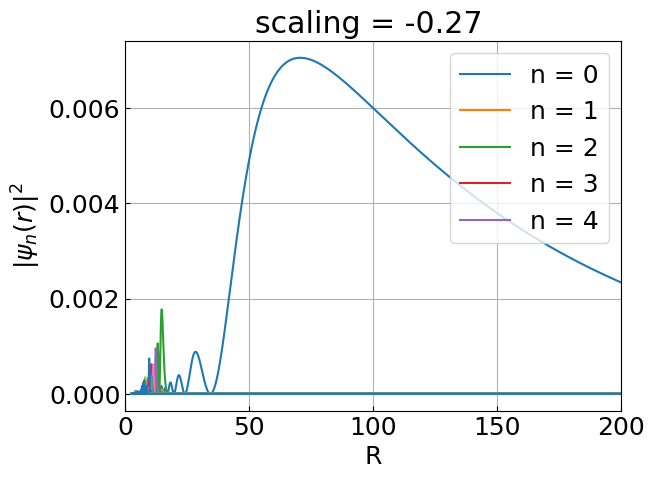

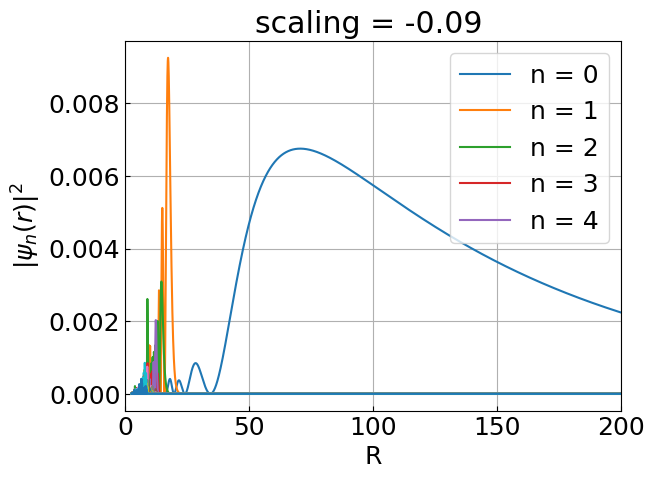

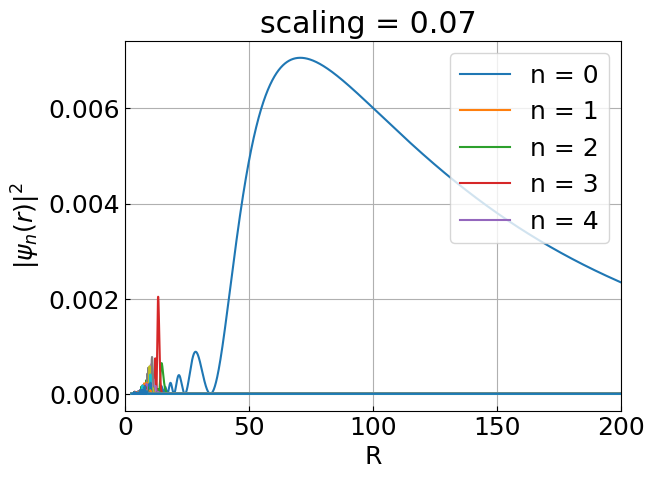

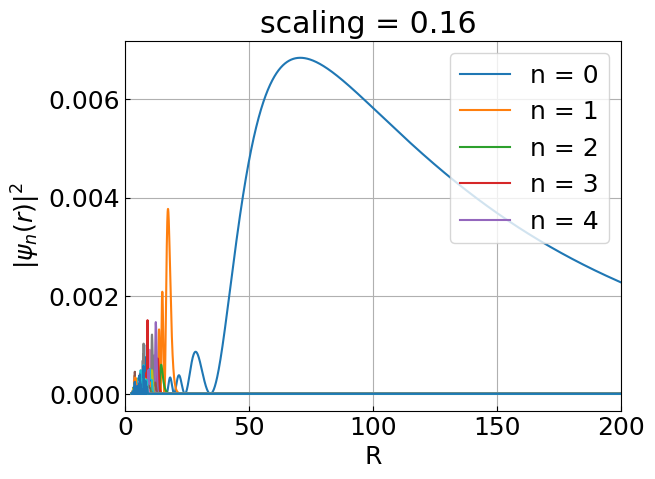

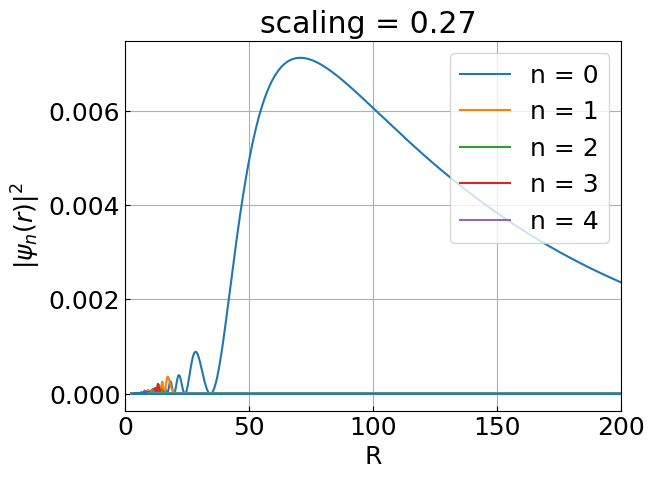

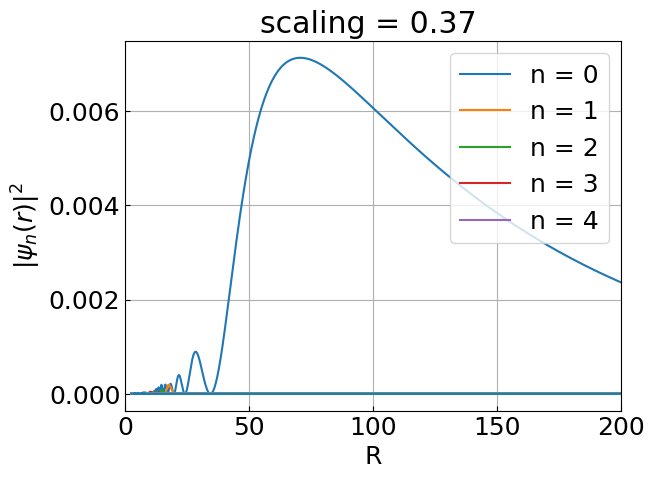

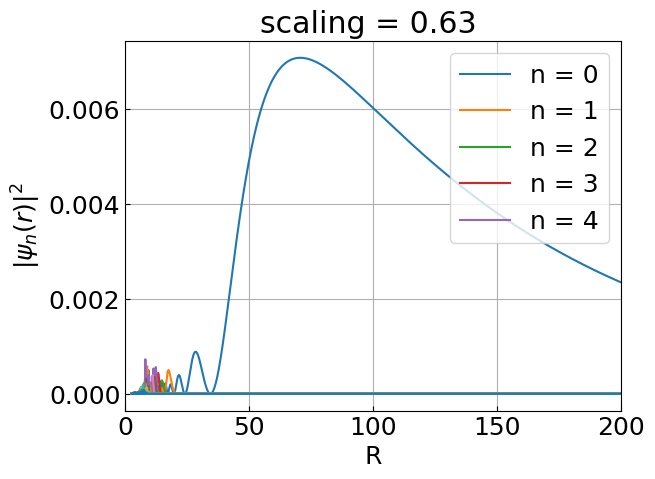

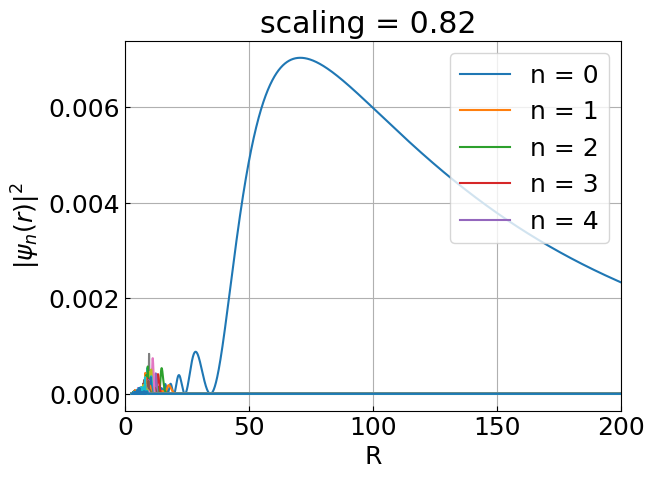

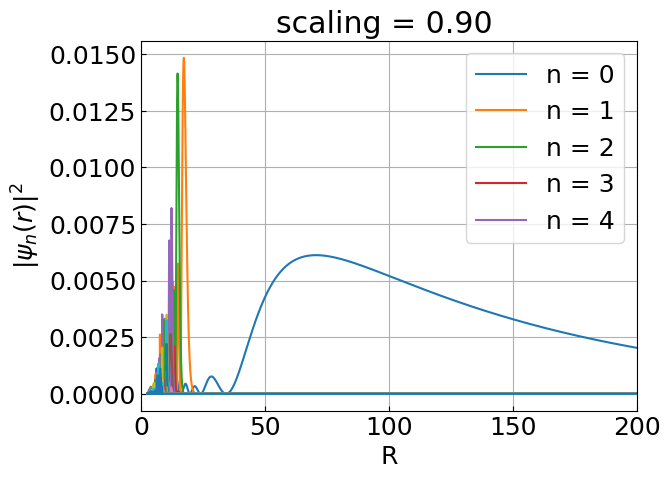

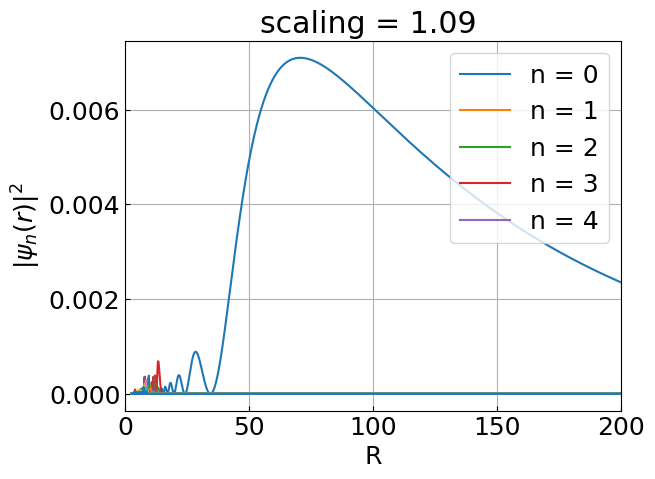

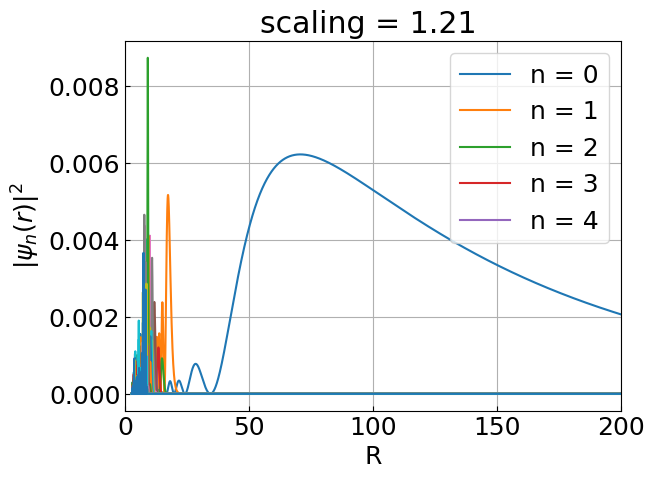

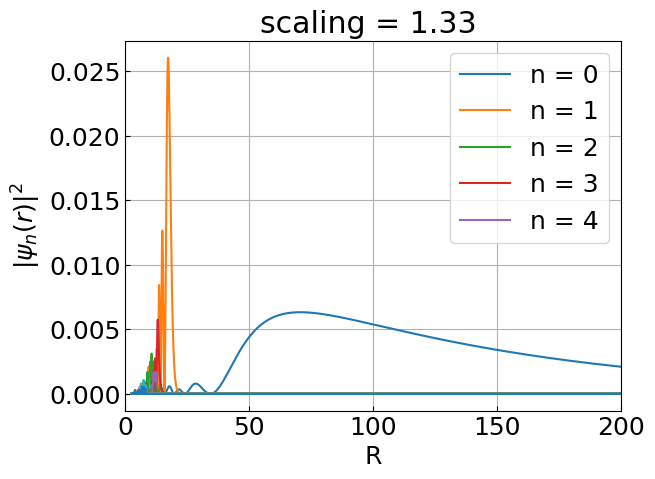

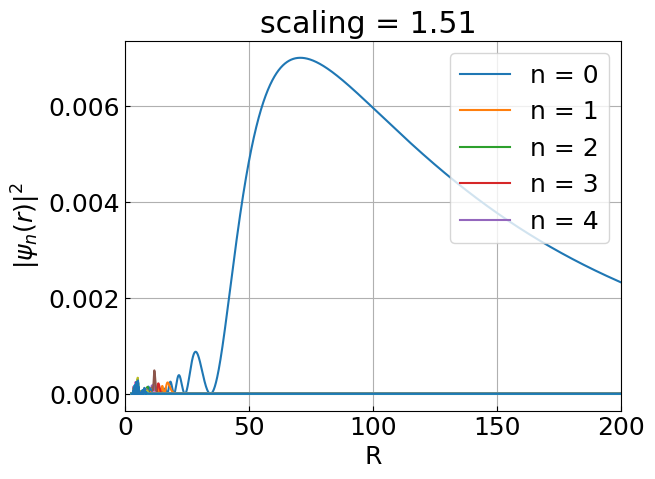

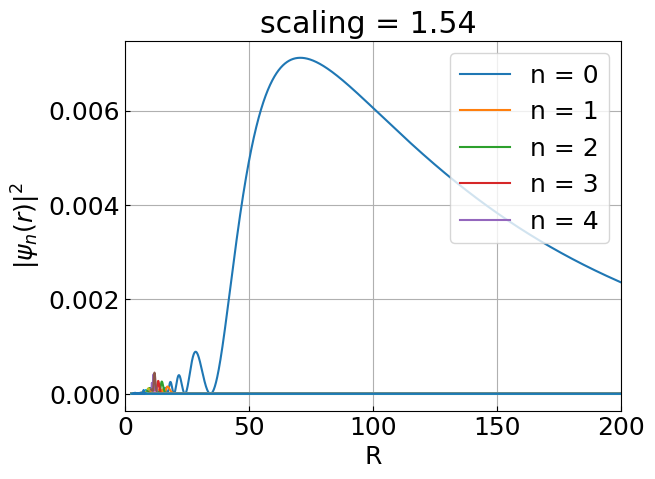

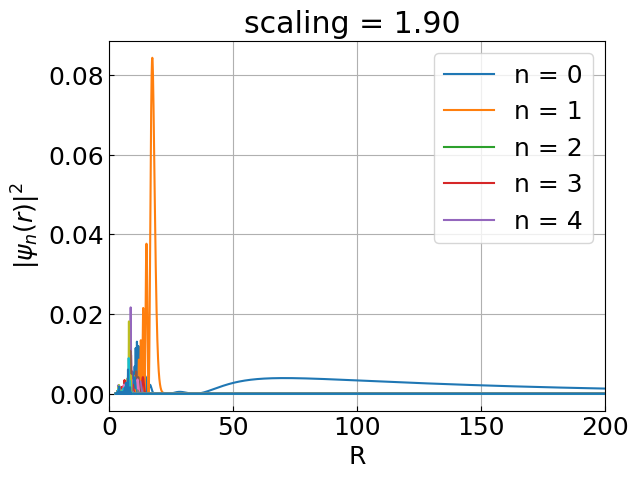

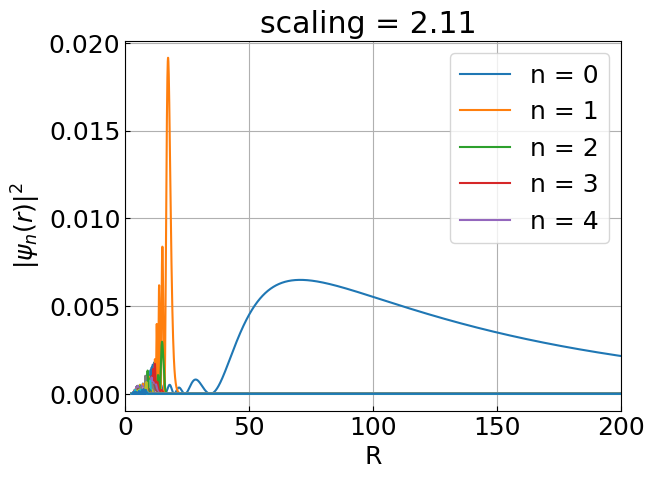

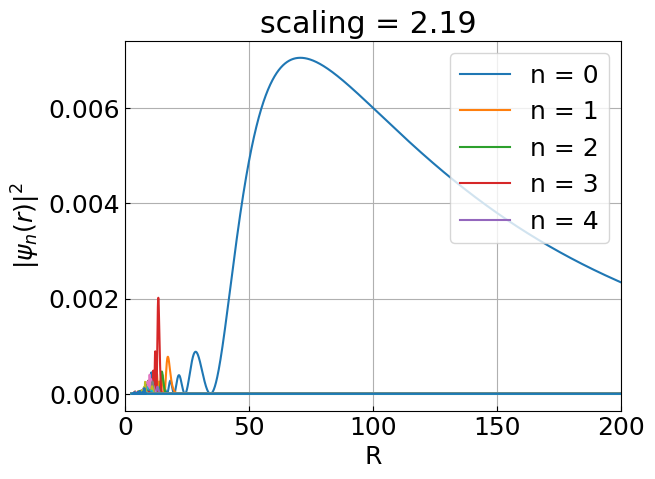

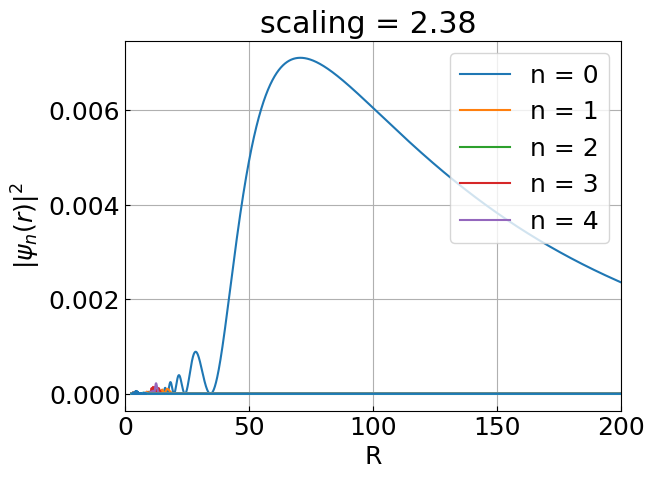

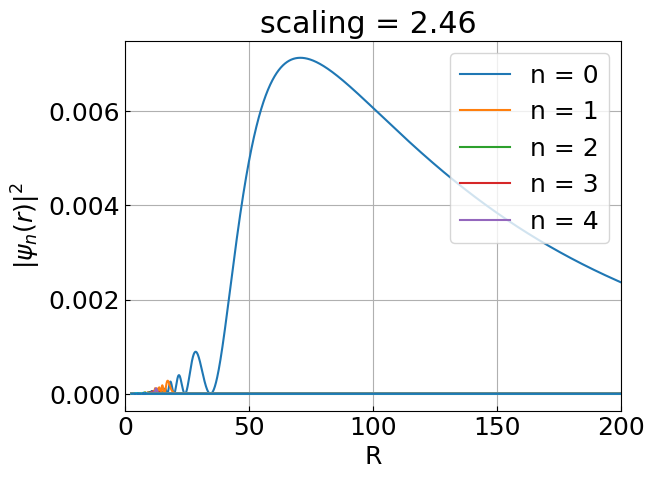

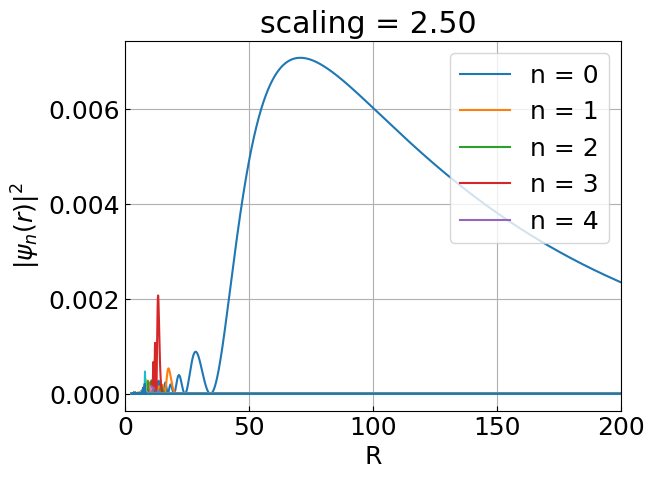

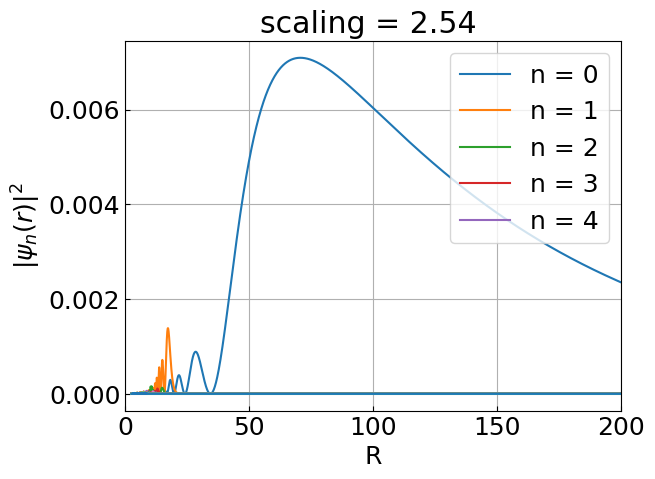

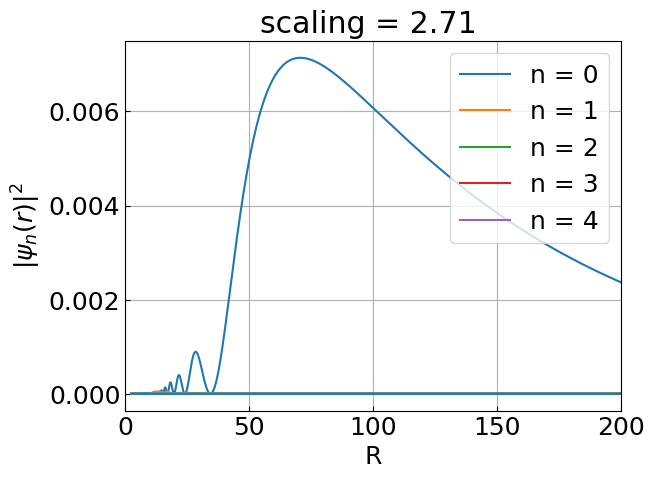

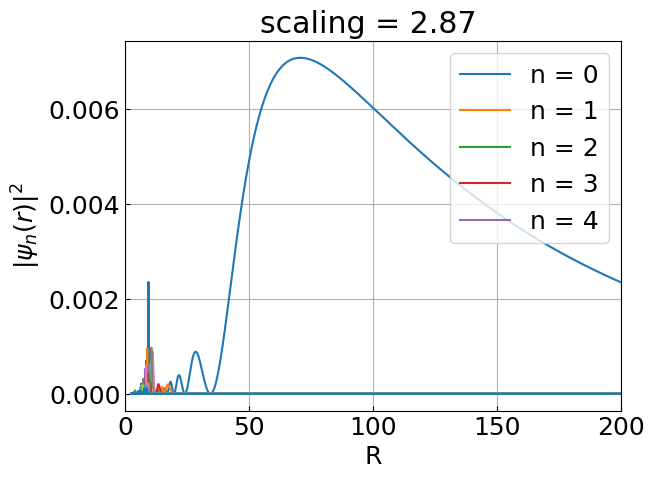

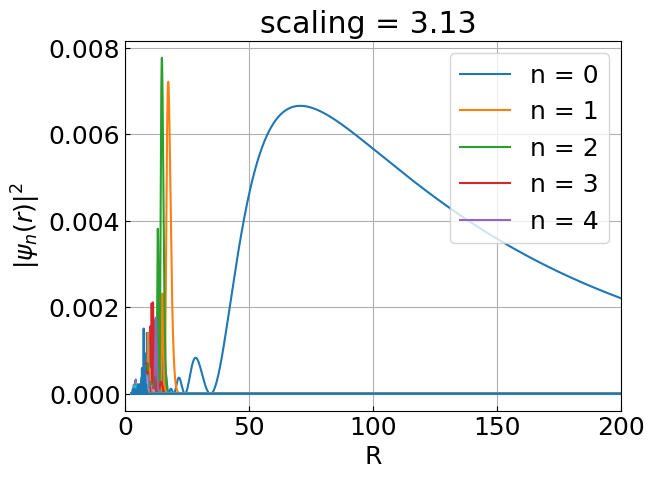

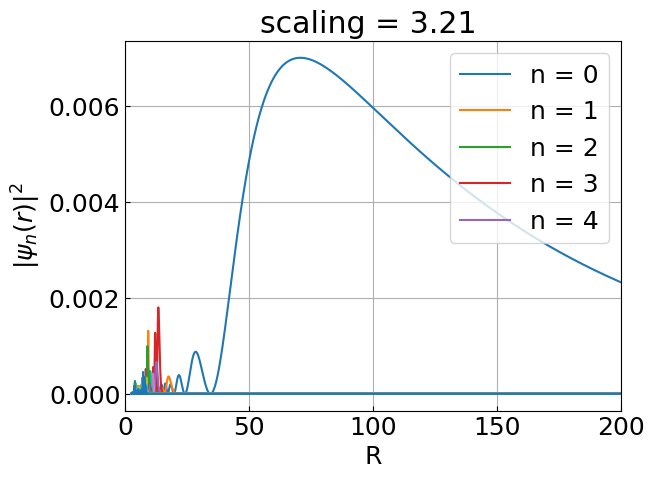

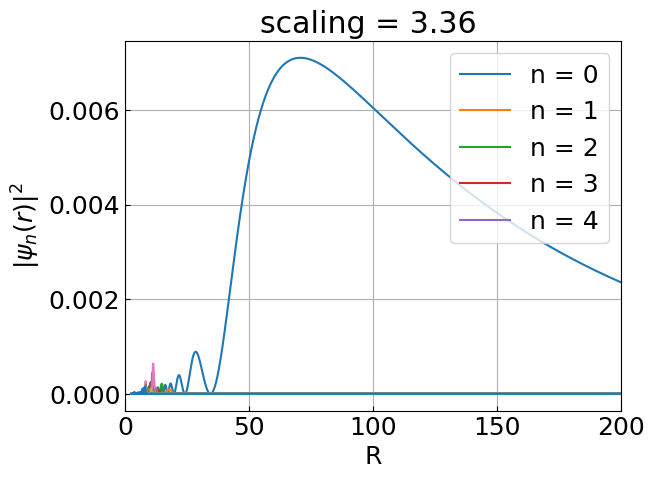

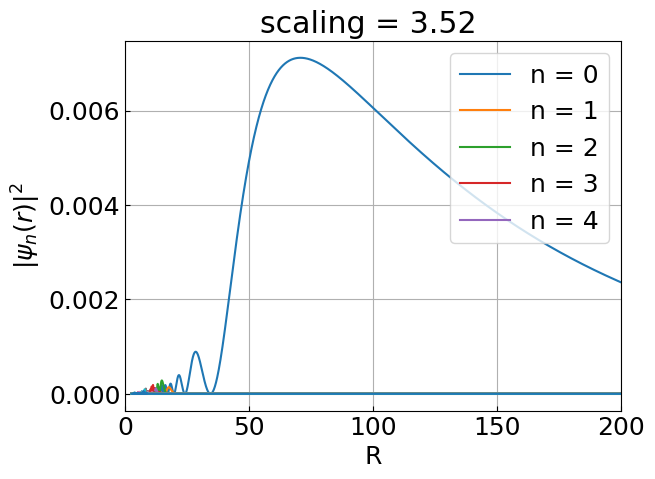

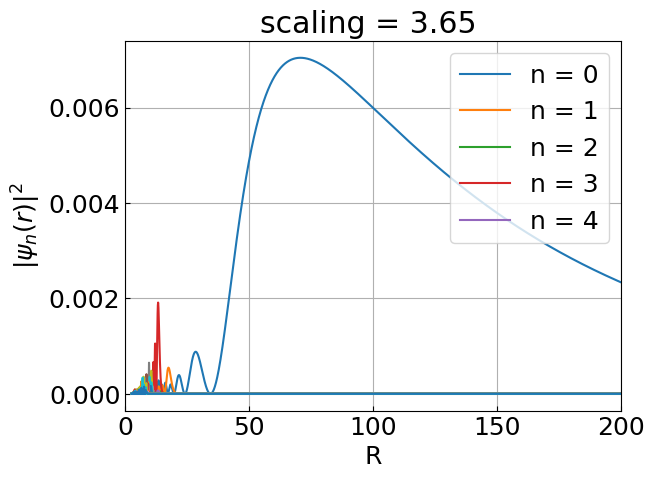

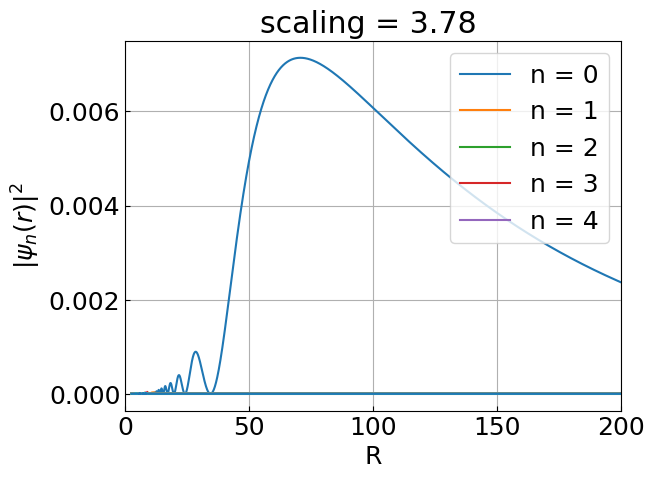

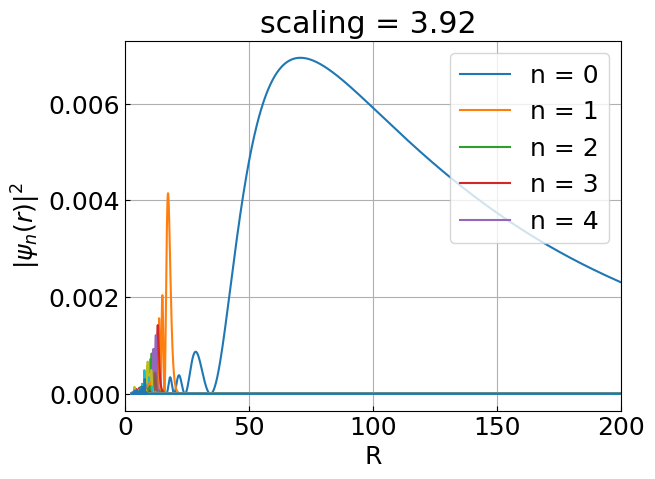

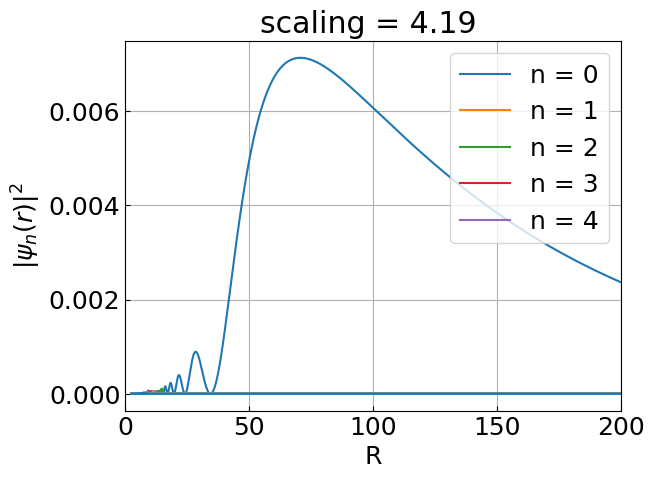

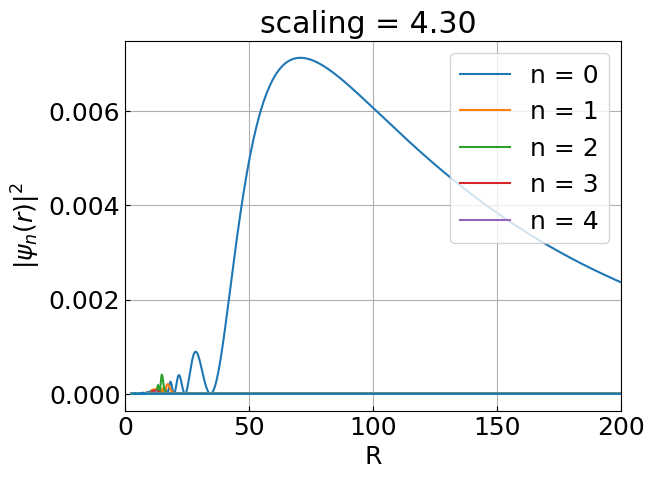

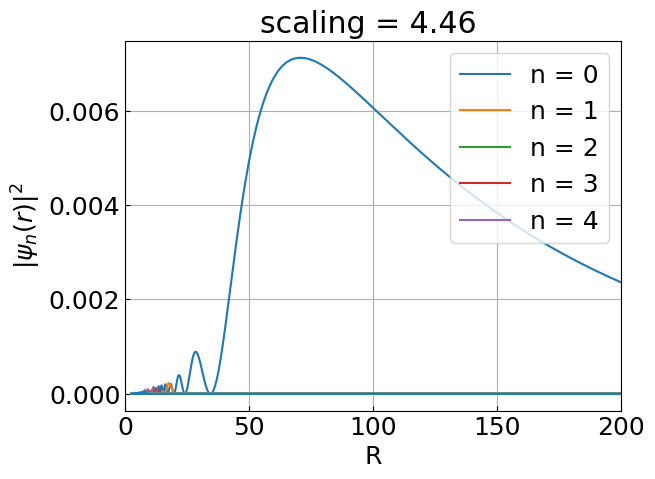

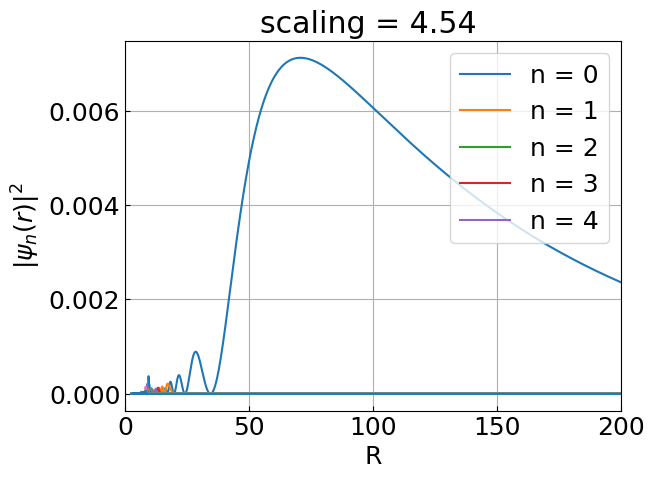

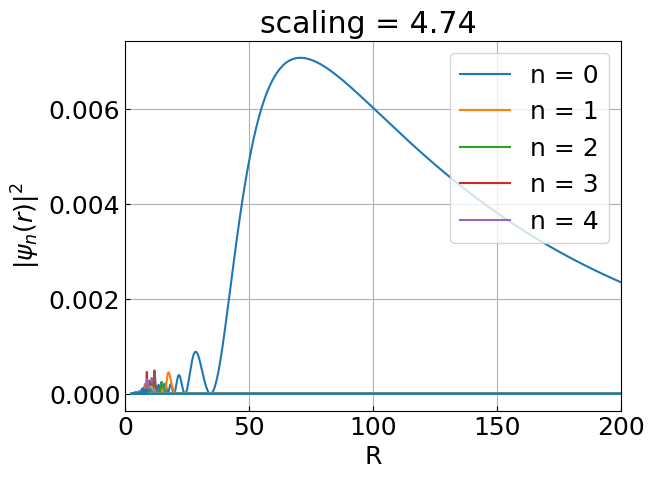

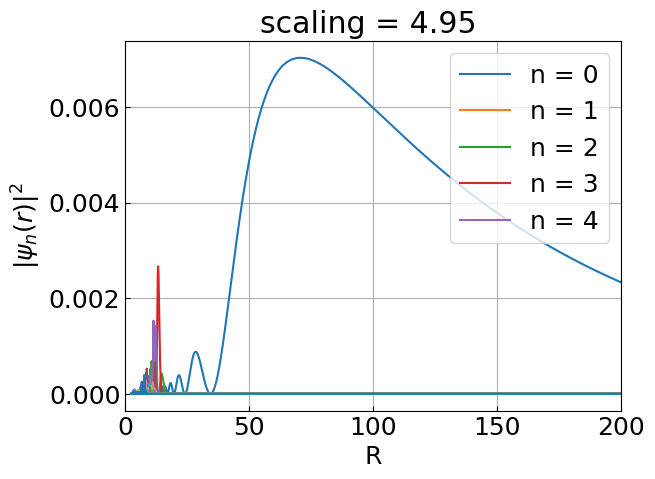

In [11]:
for wave, (node, scaled) in zip(waves, bounds.matches[0].states):
    fig, ax = utility.plot()
    ax.set_ylabel(r"$|\psi_n(r)|^2$")
    ax.plot(wave["r"], wave["coeffs"]**2)

    ax.set_xlabel("R")
    ax.set_title(f"scaling = {scaling(scaled):.2f} ")
    ax.set_xlim(0, 200)
    ax.legend([f"n = {j}" for j in range(5)], loc = "upper right")
    
# fig.savefig(f"{SAVE_PATH}/wave_function_triplet_n_10_scaled_0,60.pdf", bbox_inches="tight")

# 2D wave function view

In [18]:
from scipy.special import legendre_p_all

def plot_2d_wave(ax: Axes, wave, energy = None, scale = None, n_max = 175, n_angles = 100, log = False, r_max = 50):
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([r_max])

    angles = np.linspace(0, 2 * np.pi, n_angles)
    legendre = np.squeeze(legendre_p_all(n_max, np.cos(angles)))

    distances = wave["r"]

    ax.set_ylim(0, r_max)
    distances = distances[distances < r_max]
    wave_n = wave["coeffs"][:distances.shape[0], :]

    print(distances, distances.shape)

    wave_angles = wave_n @ legendre

    density = wave_angles**2
    if log:
        density = np.log(density)

    ax.contourf(angles, distances, density, levels = 50)
    if energy is not None or scale is not None:
        title = ""
        if energy is not None:
            title += f"energy: {float(energy):.3f} GHz\n"
        if scale is not None:
            title += f"scaling: {float(scale):.3f}"
        ax.set_title(title.strip())

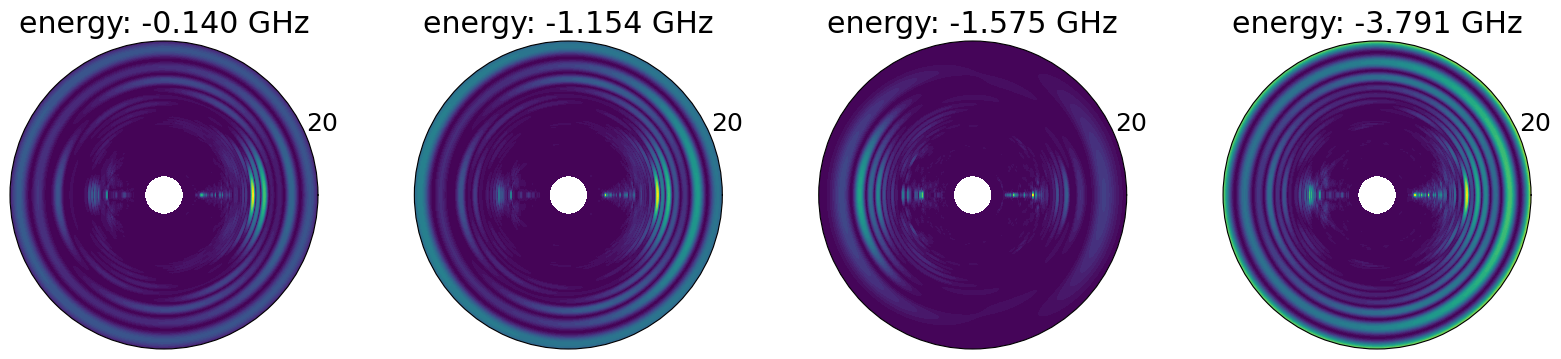

In [64]:
take = 4
fig, axes = plt.subplots(1, 4, subplot_kw=dict(projection="polar"), figsize = (20, 4))

waves = parse_wavefunction_file(f'{DATA_PATH}/wave_function_singlet_175_scaled.output', 176)

for i, wave in itertools.islice(enumerate(reversed(waves.values())), take):
    plot_2d_wave(axes[i], wave, energy = f"{wave["energy"]}", r_max = 20)

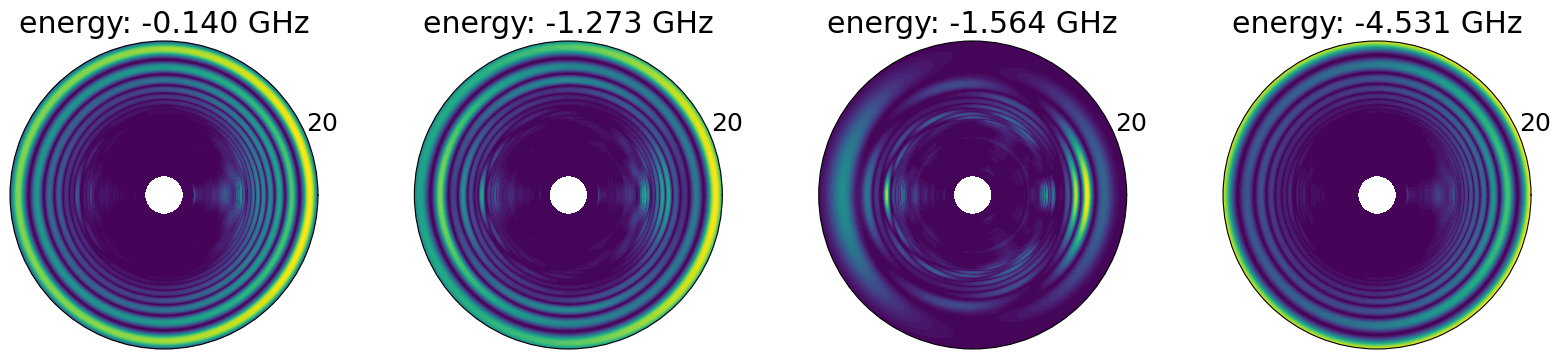

In [10]:
take = 4
fig, axes = plt.subplots(1, 4, subplot_kw=dict(projection="polar"), figsize = (20, 4))

waves = parse_wavefunction_file(f"{DATA_PATH}/bound_wave_singlet_n_10_scaled_1.0036_v2.output", 11)

for i, wave in itertools.islice(enumerate(reversed(waves.values())), take):
    plot_2d_wave(axes[i], wave, energy = f"{wave["energy"]}", r_max = 20, n_max = 10)

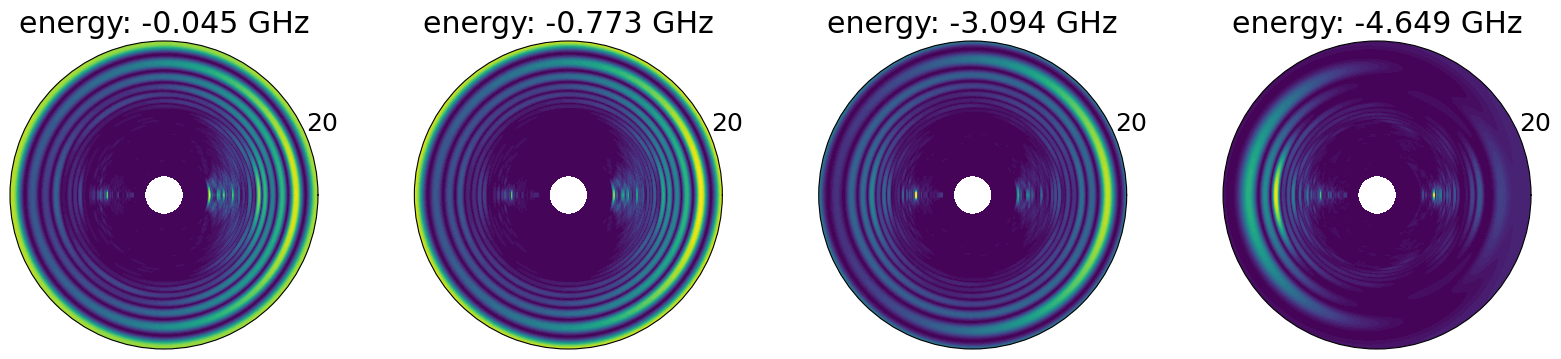

In [65]:
take = 4
fig, axes = plt.subplots(1, 4, subplot_kw=dict(projection="polar"), figsize = (20, 4))

waves = parse_wavefunction_file(f'{DATA_PATH}/wave_function_triplet_175_scaled.output', 176)

for i, wave in itertools.islice(enumerate(reversed(waves.values())), take):
    plot_2d_wave(axes[i], wave, energy = f"{wave["energy"]}", r_max = 20)

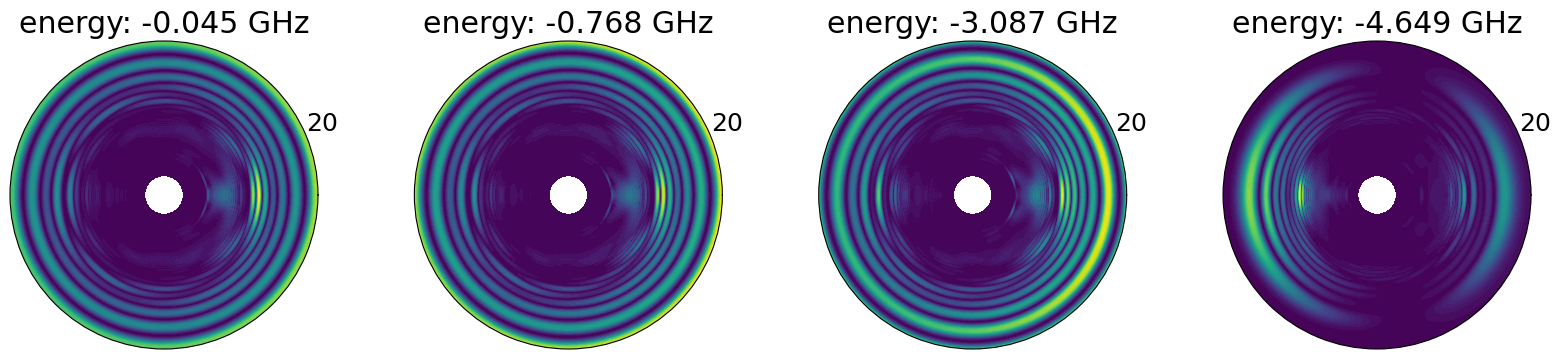

In [5]:
take = 4
fig, axes = plt.subplots(1, 4, subplot_kw=dict(projection="polar"), figsize = (20, 4))

waves = parse_wavefunction_file(f"{DATA_PATH}/bound_wave_triplet_n_10_scaled_1.007_v2.output", 11)

for i, wave in itertools.islice(enumerate(reversed(waves.values())), take):
    plot_2d_wave(axes[i], wave, energy = f"{wave["energy"]}", r_max = 20, n_max = 10)